<h1>Segmentation and Comparison of Neighborhood of Toronto & New York Using Foursquare API and Clustering</h1>

<h2>Install and import required packages</h2>

In [2]:
!pip install bs4
!pip install lxml
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

  Stored in directory: /home/dsxuser/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    ------------------------

In [3]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
import random 
from geopy.geocoders import Nominatim 
from IPython.display import Image 
from IPython.core.display import HTML 
from IPython.display import display_html 

from pandas.io.json import json_normalize

import folium 
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from matplotlib import pyplot as plt



from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules


from matplotlib import pyplot as plt


from IPython.display import HTML


In [4]:
#Function to get nearby venues
CLIENT_ID = 'VW4IYSJWZOV5MEUTYKEWPEINY3TZWYE0GJHVKNUQUSJ5DVFW' # your Foursquare ID
CLIENT_SECRET = 'NORPTKWY0S0MX3LH53PPQPJ410DHEFFJMVU055BAKPE1QAH4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=500
radius=750
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [33]:
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"



<h1 style="color:red;"><i>Segmentation for Toronto</i></h1>

<h2>Scrape the Canada data from the Wikipage using Beautiful Soup</h2>

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')

soup


tables=soup.find_all("table",{"class":"wikitable sortable"})

import re
def process_num(num):
    return float(re.sub(r'[^\w\s.]','',num))

num1 = float(re.sub(r'[^\w\s.]','','1,156.30'))
tables

[<table class="wikitable sortable">
 <tbody><tr>
 <th>Postcode</th>
 <th>Borough</th>
 <th>Neighbourhood
 </th></tr>
 <tr>
 <td>M1A</td>
 <td>Not assigned</td>
 <td>Not assigned
 </td></tr>
 <tr>
 <td>M2A</td>
 <td>Not assigned</td>
 <td>Not assigned
 </td></tr>
 <tr>
 <td>M3A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
 </td></tr>
 <tr>
 <td>M4A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
 </td></tr>
 <tr>
 <td>M5A</td>
 <td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
 <td><a href="/wiki/Regent_Park" title="Regent Park">Harbourfront</a>
 </td></tr>
 <tr>
 <td>M6A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Lawrence_Heights" title="Lawrence Heights">Lawrence Heights</a>
 </td></tr>
 <tr>


<h2>Clean and process data</h2>

In [6]:
postcodes = []
Boroughs = []
TorNeighbourhoods = []

for table in tables:
    rows = table.find_all('tr')
        
    for row in rows:
        cells = row.find_all('td')
        
        
        if len(cells) > 1:
            postcode = cells[0]
            postcodes.append(postcode.text.strip())
            
            Borough = cells[1]
            Boroughs.append(Borough.text.strip())
            
            Neighbourhood = cells[2]
            TorNeighbourhoods.append(Neighbourhood.text.strip())
            
df1 = pd.DataFrame(postcodes, columns = ['Postcode'])
df1

df1['Borough'] = Boroughs
df1

df1['Neighbourhood'] = TorNeighbourhoods
df1


Postcode           Borough  \
0        M1A      Not assigned   
1        M2A      Not assigned   
2        M3A        North York   
3        M4A        North York   
4        M5A  Downtown Toronto   
5        M6A        North York   
6        M6A        North York   
7        M7A  Downtown Toronto   
8        M8A      Not assigned   
9        M9A         Etobicoke   
10       M1B       Scarborough   
11       M1B       Scarborough   
12       M2B      Not assigned   
13       M3B        North York   
14       M4B         East York   
15       M4B         East York   
16       M5B  Downtown Toronto   
17       M5B  Downtown Toronto   
18       M6B        North York   
19       M7B      Not assigned   
20       M8B      Not assigned   
21       M9B         Etobicoke   
22       M9B         Etobicoke   
23       M9B         Etobicoke   
24       M9B         Etobicoke   
25       M9B         Etobicoke   
26       M1C       Scarborough   
27       M1C       Scarborough   
28       M1C       Scarborough   
29       M2C      Not assigned   
..       ...               ...   
257      M9X      Not assigned   
258      M1Y      Not assigned   
259      M2Y      Not assigned   
260      M3Y      Not assigned   
261      M4Y  Downtown Toronto   
262      M5Y      Not assigned   
263      M6Y      Not assigned   
264      M7Y      East Toronto   
265      M8Y         Etobicoke   
266      M8Y         Etobicoke   
267      M8Y         Etobicoke   
268      M8Y         Etobicoke   
269      M8Y         Etobicoke   
270      M8Y         Etobicoke   
271      M8Y         Etobicoke   
272      M8Y         Etobicoke   
273      M9Y      Not assigned   
274      M1Z      Not assigned   
275      M2Z      Not assigned   
276      M3Z      Not assigned   
277      M4Z      Not assigned   
278      M5Z      Not assigned   
279      M6Z      Not assigned   
280      M7Z      Not assigned   
281      M8Z         Etobicoke   
282      M8Z         Etobicoke   
283      M8Z         Etobicoke   
284      M8Z         Etobicoke   
285      M8Z         Etobicoke   
286      M9Z      Not assigned   

                                         Neighbourhood  
0                                         Not assigned  
1                                         Not assigned  
2                                            Parkwoods  
3                                     Victoria Village  
4                                         Harbourfront  
5                                     Lawrence Heights  
6                                       Lawrence Manor  
7                                         Queen's Park  
8                                         Not assigned  
9                                     Islington Avenue  
10                                               Rouge  
11                                             Malvern  
12                                        Not assigned  
13                                     Don Mills North  
14                                    Woodbine Gardens  
15                                       Parkview Hill  
16                                             Ryerson  
17                                     Garden District  
18                                           Glencairn  
19                                        Not assigned  
20                                        Not assigned  
21                                          Cloverdale  
22                                           Islington  
23                                        Martin Grove  
24                                    Princess Gardens  
25                                     West Deane Park  
26                                      Highland Creek  
27                                          Rouge Hill  
28                                          Port Union  
29                                        Not assigned  
..                                                 ...  
257                                       Not assigned  
258           

<h4>Dropping the rows where Borough is 'Not assigned'</h4>


In [7]:
df1 = df1[df1.Borough != 'Not assigned']
df1

Postcode           Borough  \
2        M3A        North York   
3        M4A        North York   
4        M5A  Downtown Toronto   
5        M6A        North York   
6        M6A        North York   
7        M7A  Downtown Toronto   
9        M9A         Etobicoke   
10       M1B       Scarborough   
11       M1B       Scarborough   
13       M3B        North York   
14       M4B         East York   
15       M4B         East York   
16       M5B  Downtown Toronto   
17       M5B  Downtown Toronto   
18       M6B        North York   
21       M9B         Etobicoke   
22       M9B         Etobicoke   
23       M9B         Etobicoke   
24       M9B         Etobicoke   
25       M9B         Etobicoke   
26       M1C       Scarborough   
27       M1C       Scarborough   
28       M1C       Scarborough   
30       M3C        North York   
31       M3C        North York   
32       M4C         East York   
33       M5C  Downtown Toronto   
34       M6C              York   
37       M9C         Etobicoke   
38       M9C         Etobicoke   
..       ...               ...   
234      M9V         Etobicoke   
235      M1W       Scarborough   
238      M4W  Downtown Toronto   
239      M5W  Downtown Toronto   
242      M8W         Etobicoke   
243      M8W         Etobicoke   
244      M9W         Etobicoke   
245      M1X       Scarborough   
248      M4X  Downtown Toronto   
249      M4X  Downtown Toronto   
250      M5X  Downtown Toronto   
251      M5X  Downtown Toronto   
254      M8X         Etobicoke   
255      M8X         Etobicoke   
256      M8X         Etobicoke   
261      M4Y  Downtown Toronto   
264      M7Y      East Toronto   
265      M8Y         Etobicoke   
266      M8Y         Etobicoke   
267      M8Y         Etobicoke   
268      M8Y         Etobicoke   
269      M8Y         Etobicoke   
270      M8Y         Etobicoke   
271      M8Y         Etobicoke   
272      M8Y         Etobicoke   
281      M8Z         Etobicoke   
282      M8Z         Etobicoke   
283      M8Z         Etobicoke   
284      M8Z         Etobicoke   
285      M8Z         Etobicoke   

                                         Neighbourhood  
2                                            Parkwoods  
3                                     Victoria Village  
4                                         Harbourfront  
5                                     Lawrence Heights  
6                                       Lawrence Manor  
7                                         Queen's Park  
9                                     Islington Avenue  
10                                               Rouge  
11                                             Malvern  
13                                     Don Mills North  
14                                    Woodbine Gardens  
15                                       Parkview Hill  
16                                             Ryerson  
17                                     Garden District  
18                                           Glencairn  
21                                          Cloverdale  
22                                           Islington  
23                                        Martin Grove  
24                                    Princess Gardens  
25                                     West Deane Park  
26                                      Highland Creek  
27                                          Rouge Hill  
28                                          Port Union  
30                                     Flemingdon Park  
31                                     Don Mills South  
32                                    Woodbine Heights  
33                                      St. James Town  
34                                  Humewood-Cedarvale  
37                                   Bloordale Gardens  
38                                            Eringate  
..                                                 ...  
234                                        Thistletown  
235           

<h4>Combining the neighbourhoods with same Postalcode</h4>

In [8]:
df2 = df1.groupby(['Postcode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)
df2

Postcode           Borough  \
0        M3A        North York   
1        M4A        North York   
2        M5A  Downtown Toronto   
3        M6A        North York   
4        M7A  Downtown Toronto   
5        M9A         Etobicoke   
6        M1B       Scarborough   
7        M3B        North York   
8        M4B         East York   
9        M5B  Downtown Toronto   
10       M6B        North York   
11       M9B         Etobicoke   
12       M1C       Scarborough   
13       M3C        North York   
14       M4C         East York   
15       M5C  Downtown Toronto   
16       M6C              York   
17       M9C         Etobicoke   
18       M1E       Scarborough   
19       M4E      East Toronto   
20       M5E  Downtown Toronto   
21       M6E              York   
22       M1G       Scarborough   
23       M4G         East York   
24       M5G  Downtown Toronto   
25       M6G  Downtown Toronto   
26       M1H       Scarborough   
27       M2H        North York   
28       M3H        North York   
29       M4H         East York   
..       ...               ...   
73       M4R   Central Toronto   
74       M5R   Central Toronto   
75       M6R      West Toronto   
76       M7R       Mississauga   
77       M9R         Etobicoke   
78       M1S       Scarborough   
79       M4S   Central Toronto   
80       M5S  Downtown Toronto   
81       M6S      West Toronto   
82       M1T       Scarborough   
83       M4T   Central Toronto   
84       M5T  Downtown Toronto   
85       M1V       Scarborough   
86       M4V   Central Toronto   
87       M5V  Downtown Toronto   
88       M8V         Etobicoke   
89       M9V         Etobicoke   
90       M1W       Scarborough   
91       M4W  Downtown Toronto   
92       M5W  Downtown Toronto   
93       M8W         Etobicoke   
94       M9W         Etobicoke   
95       M1X       Scarborough   
96       M4X  Downtown Toronto   
97       M5X  Downtown Toronto   
98       M8X         Etobicoke   
99       M4Y  Downtown Toronto   
100      M7Y      East Toronto   
101      M8Y         Etobicoke   
102      M8Z         Etobicoke   

                                         Neighbourhood  
0                                            Parkwoods  
1                                     Victoria Village  
2                                         Harbourfront  
3                     Lawrence Heights, Lawrence Manor  
4                                         Queen's Park  
5                                     Islington Avenue  
6                                       Rouge, Malvern  
7                                      Don Mills North  
8                      Woodbine Gardens, Parkview Hill  
9                             Ryerson, Garden District  
10                                           Glencairn  
11   Cloverdale, Islington, Martin Grove, Princess ...  
12              Highland Creek, Rouge Hill, Port Union  
13                    Flemingdon Park, Don Mills South  
14                                    Woodbine Heights  
15                                      St. James Town  
16                                  Humewood-Cedarvale  
17   Bloordale Gardens, Eringate, Markland Wood, Ol...  
18                   Guildwood, Morningside, West Hill  
19                                         The Beaches  
20                                         Berczy Park  
21                                 Caledonia-Fairbanks  
22                                              Woburn  
23                                             Leaside  
24                                  Central Bay Street  
25                                            Christie  
26                                           Cedarbrae  
27                                   Hillcrest Village  
28     Bathurst Manor, Downsview North, Wilson Heights  
29                                    Thorncliffe Park  
..                                                 ...  
73                                  North Toronto West  
74            


<h4>Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough</h4>



In [9]:
df2['Neighbourhood'] = np.where(df2['Neighbourhood'] == 'Not assigned',df2['Borough'], df2['Neighbourhood'])

df2.reset_index(inplace=True)
TorNeighbourhoods=df2
TorNeighbourhoods

index Postcode           Borough  \
0        0      M3A        North York   
1        1      M4A        North York   
2        2      M5A  Downtown Toronto   
3        3      M6A        North York   
4        4      M7A  Downtown Toronto   
5        5      M9A         Etobicoke   
6        6      M1B       Scarborough   
7        7      M3B        North York   
8        8      M4B         East York   
9        9      M5B  Downtown Toronto   
10      10      M6B        North York   
11      11      M9B         Etobicoke   
12      12      M1C       Scarborough   
13      13      M3C        North York   
14      14      M4C         East York   
15      15      M5C  Downtown Toronto   
16      16      M6C              York   
17      17      M9C         Etobicoke   
18      18      M1E       Scarborough   
19      19      M4E      East Toronto   
20      20      M5E  Downtown Toronto   
21      21      M6E              York   
22      22      M1G       Scarborough   
23      23      M4G         East York   
24      24      M5G  Downtown Toronto   
25      25      M6G  Downtown Toronto   
26      26      M1H       Scarborough   
27      27      M2H        North York   
28      28      M3H        North York   
29      29      M4H         East York   
..     ...      ...               ...   
73      73      M4R   Central Toronto   
74      74      M5R   Central Toronto   
75      75      M6R      West Toronto   
76      76      M7R       Mississauga   
77      77      M9R         Etobicoke   
78      78      M1S       Scarborough   
79      79      M4S   Central Toronto   
80      80      M5S  Downtown Toronto   
81      81      M6S      West Toronto   
82      82      M1T       Scarborough   
83      83      M4T   Central Toronto   
84      84      M5T  Downtown Toronto   
85      85      M1V       Scarborough   
86      86      M4V   Central Toronto   
87      87      M5V  Downtown Toronto   
88      88      M8V         Etobicoke   
89      89      M9V         Etobicoke   
90      90      M1W       Scarborough   
91      91      M4W  Downtown Toronto   
92      92      M5W  Downtown Toronto   
93      93      M8W         Etobicoke   
94      94      M9W         Etobicoke   
95      95      M1X       Scarborough   
96      96      M4X  Downtown Toronto   
97      97      M5X  Downtown Toronto   
98      98      M8X         Etobicoke   
99      99      M4Y  Downtown Toronto   
100    100      M7Y      East Toronto   
101    101      M8Y         Etobicoke   
102    102      M8Z         Etobicoke   

                                         Neighbourhood  
0                                            Parkwoods  
1                                     Victoria Village  
2                                         Harbourfront  
3                     Lawrence Heights, Lawrence Manor  
4                                         Queen's Park  
5                                     Islington Avenue  
6                                       Rouge, Malvern  
7                                      Don Mills North  
8                      Woodbine Gardens, Parkview Hill  
9                             Ryerson, Garden District  
10                                           Glencairn  
11   Cloverdale, Islington, Martin Grove, Princess ...  
12              Highland Creek, Rouge Hill, Port Union  
13                    Flemingdon Park, Don Mills South  
14                                    Woodbine Heights  
15                                      St. James Town  
16                                  Humewood-Cedarvale  
17   Bloordale Gardens, Eringate, Markland Wood, Ol...  
18                   Guildwood, Morningside, West Hill  
19                                         The Beaches  
20                                         Berczy Park  
21                                 Caledonia-Fairbanks  
22                                              Woburn  
23                                             Leaside  
24                                  C

In [20]:
# Shape of data frame


<h4>Merging records where multiple neighborhoods share the same borough</h4>



In [10]:
TorNeighbourhoods = (TorNeighbourhoods.groupby(['Postcode', 'Borough'])['Neighbourhood']
      .apply(lambda x: "{}".format(', '.join(x))).reset_index())
TorNeighbourhoods

Postcode           Borough  \
0        M1B       Scarborough   
1        M1C       Scarborough   
2        M1E       Scarborough   
3        M1G       Scarborough   
4        M1H       Scarborough   
5        M1J       Scarborough   
6        M1K       Scarborough   
7        M1L       Scarborough   
8        M1M       Scarborough   
9        M1N       Scarborough   
10       M1P       Scarborough   
11       M1R       Scarborough   
12       M1S       Scarborough   
13       M1T       Scarborough   
14       M1V       Scarborough   
15       M1W       Scarborough   
16       M1X       Scarborough   
17       M2H        North York   
18       M2J        North York   
19       M2K        North York   
20       M2L        North York   
21       M2M        North York   
22       M2N        North York   
23       M2P        North York   
24       M2R        North York   
25       M3A        North York   
26       M3B        North York   
27       M3C        North York   
28       M3H        North York   
29       M3J        North York   
..       ...               ...   
73       M6C              York   
74       M6E              York   
75       M6G  Downtown Toronto   
76       M6H      West Toronto   
77       M6J      West Toronto   
78       M6K      West Toronto   
79       M6L        North York   
80       M6M              York   
81       M6N              York   
82       M6P      West Toronto   
83       M6R      West Toronto   
84       M6S      West Toronto   
85       M7A  Downtown Toronto   
86       M7R       Mississauga   
87       M7Y      East Toronto   
88       M8V         Etobicoke   
89       M8W         Etobicoke   
90       M8X         Etobicoke   
91       M8Y         Etobicoke   
92       M8Z         Etobicoke   
93       M9A         Etobicoke   
94       M9B         Etobicoke   
95       M9C         Etobicoke   
96       M9L        North York   
97       M9M        North York   
98       M9N              York   
99       M9P         Etobicoke   
100      M9R         Etobicoke   
101      M9V         Etobicoke   
102      M9W         Etobicoke   

                                         Neighbourhood  
0                                       Rouge, Malvern  
1               Highland Creek, Rouge Hill, Port Union  
2                    Guildwood, Morningside, West Hill  
3                                               Woburn  
4                                            Cedarbrae  
5                                  Scarborough Village  
6          East Birchmount Park, Ionview, Kennedy Park  
7                      Clairlea, Golden Mile, Oakridge  
8      Cliffcrest, Cliffside, Scarborough Village West  
9                          Birch Cliff, Cliffside West  
10   Dorset Park, Scarborough Town Centre, Wexford ...  
11                                   Maryvale, Wexford  
12                                           Agincourt  
13             Clarks Corners, Sullivan, Tam O'Shanter  
14   Agincourt North, L'Amoreaux East, Milliken, St...  
15                                     L'Amoreaux West  
16                                         Upper Rouge  
17                                   Hillcrest Village  
18                        Fairview, Henry Farm, Oriole  
19                                     Bayview Village  
20                            Silver Hills, York Mills  
21                             Newtonbrook, Willowdale  
22                                    Willowdale South  
23                                     York Mills West  
24                                     Willowdale West  
25                                           Parkwoods  
26                                     Don Mills North  
27                    Flemingdon Park, Don Mills South  
28     Bathurst Manor, Downsview North, Wilson Heights  
29                     Northwood Park, York University  
..                                                 ...  
73                                  Humewood-Cedarvale  
74            

In [22]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(TorNeighbourhoods['Borough'].unique()),
        TorNeighbourhoods.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


<h4>Fetch all data related to Toronto as the Borough</h4>

In [11]:
TorNeighbourhoods = TorNeighbourhoods[TorNeighbourhoods['Borough'].str.contains('Toronto',regex=False)]

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(TorNeighbourhoods['Borough'].unique()),
        TorNeighbourhoods.shape[0]
    )
)
TorNeighbourhoods

The dataframe has 4 boroughs and 39 neighborhoods.


Postcode           Borough  \
37      M4E      East Toronto   
41      M4K      East Toronto   
42      M4L      East Toronto   
43      M4M      East Toronto   
44      M4N   Central Toronto   
45      M4P   Central Toronto   
46      M4R   Central Toronto   
47      M4S   Central Toronto   
48      M4T   Central Toronto   
49      M4V   Central Toronto   
50      M4W  Downtown Toronto   
51      M4X  Downtown Toronto   
52      M4Y  Downtown Toronto   
53      M5A  Downtown Toronto   
54      M5B  Downtown Toronto   
55      M5C  Downtown Toronto   
56      M5E  Downtown Toronto   
57      M5G  Downtown Toronto   
58      M5H  Downtown Toronto   
59      M5J  Downtown Toronto   
60      M5K  Downtown Toronto   
61      M5L  Downtown Toronto   
63      M5N   Central Toronto   
64      M5P   Central Toronto   
65      M5R   Central Toronto   
66      M5S  Downtown Toronto   
67      M5T  Downtown Toronto   
68      M5V  Downtown Toronto   
69      M5W  Downtown Toronto   
70      M5X  Downtown Toronto   
75      M6G  Downtown Toronto   
76      M6H      West Toronto   
77      M6J      West Toronto   
78      M6K      West Toronto   
82      M6P      West Toronto   
83      M6R      West Toronto   
84      M6S      West Toronto   
85      M7A  Downtown Toronto   
87      M7Y      East Toronto   

                                        Neighbourhood  
37                                        The Beaches  
41                       The Danforth West, Riverdale  
42                     The Beaches West, India Bazaar  
43                                    Studio District  
44                                      Lawrence Park  
45                                   Davisville North  
46                                 North Toronto West  
47                                         Davisville  
48                        Moore Park, Summerhill East  
49  Deer Park, Forest Hill SE, Rathnelly, South Hi...  
50                                           Rosedale  
51                        Cabbagetown, St. James Town  
52                               Church and Wellesley  
53                                       Harbourfront  
54                           Ryerson, Garden District  
55                                     St. James Town  
56                                        Berczy Park  
57                                 Central Bay Street  
58                           Adelaide, King, Richmond  
59  Harbourfront East, Toronto Islands, Union Station  
60           Design Exchange, Toronto Dominion Centre  
61                     Commerce Court, Victoria Hotel  
63                                           Roselawn  
64                Forest Hill North, Forest Hill West  
65                The Annex, North Midtown, Yorkville  
66                     Harbord, University of Toronto  
67          Chinatown, Grange Park, Kensington Market  
68  CN Tower, Bathurst Quay, Island airport, Harbo...  
69                    Stn A PO Boxes 25 The Esplanade  
70             First Canadian Place, Underground city  
75                                           Christie  
76                       Dovercourt Village, Dufferin  
77                           Little Portugal, Trinity  
78       Brockton, Exhibition Place, Parkdale Village  
82                      High Park, The Junction South  
83                             Parkdale, Roncesvalles  
84                                 Runnymede, Swansea  
85                                       Queen's Park  
87  Business Reply Mail Processing Centre 969 Eastern

In [15]:
TorNeighbourhoods.loc[TorNeighbourhoods.Neighbourhood.str.contains('Not assigned'), 'Neighbourhood'] = \
TorNeighbourhoods.loc[TorNeighbourhoods.Neighbourhood.str.contains('Not assigned'), 'Borough']



/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<h2>Import CSV for Geospatial data and Merge the Dataframes to get longitudes and latitudes</h2>

In [16]:
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data/')
lat_lon.head()

lat_lon.rename(columns={'Postal Code':'Postcode'},inplace=True)
TorNeighbourhoods = pd.merge(TorNeighbourhoods,lat_lon,on='Postcode')
TorNeighbourhoods.head()


Postcode          Borough                   Neighbourhood   Latitude  \
0      M4E     East Toronto                     The Beaches  43.676357   
1      M4K     East Toronto    The Danforth West, Riverdale  43.679557   
2      M4L     East Toronto  The Beaches West, India Bazaar  43.668999   
3      M4M     East Toronto                 Studio District  43.659526   
4      M4N  Central Toronto                   Lawrence Park  43.728020   

   Longitude  
0 -79.293031  
1 -79.352188  
2 -79.315572  
3 -79.340923  
4 -79.388790

<h2>Data Map of all the neighbourhoods of Toronto</h2>

In [17]:
#Using geopy Library to get the Coordinates of Toronto¶
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

map_toronto = folium.Map(location=[latitude,longitude],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(TorNeighbourhoods['Latitude'],TorNeighbourhoods['Longitude'],TorNeighbourhoods['Borough'],TorNeighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

The geograpical coordinate of Toronto are 43.653963, -79.387207.


<h2>KMeans clustering for the clustering of the Toronto neighbourhoods</h2>

In [18]:
k=5
toronto_clustering = TorNeighbourhoods.drop(['Postcode','Borough','Neighbourhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)
kmeans.labels_
TorNeighbourhoods.insert(0, 'ClusterLabels', kmeans.labels_)
TorNeighbourhoods

ClusterLabels Postcode           Borough  \
0               0      M4E      East Toronto   
1               0      M4K      East Toronto   
2               0      M4L      East Toronto   
3               0      M4M      East Toronto   
4               1      M4N   Central Toronto   
5               1      M4P   Central Toronto   
6               1      M4R   Central Toronto   
7               1      M4S   Central Toronto   
8               1      M4T   Central Toronto   
9               1      M4V   Central Toronto   
10              4      M4W  Downtown Toronto   
11              4      M4X  Downtown Toronto   
12              4      M4Y  Downtown Toronto   
13              4      M5A  Downtown Toronto   
14              4      M5B  Downtown Toronto   
15              4      M5C  Downtown Toronto   
16              4      M5E  Downtown Toronto   
17              4      M5G  Downtown Toronto   
18              4      M5H  Downtown Toronto   
19              4      M5J  Downtown Toronto   
20              4      M5K  Downtown Toronto   
21              4      M5L  Downtown Toronto   
22              1      M5N   Central Toronto   
23              1      M5P   Central Toronto   
24              3      M5R   Central Toronto   
25              3      M5S  Downtown Toronto   
26              3      M5T  Downtown Toronto   
27              4      M5V  Downtown Toronto   
28              4      M5W  Downtown Toronto   
29              4      M5X  Downtown Toronto   
30              3      M6G  Downtown Toronto   
31              2      M6H      West Toronto   
32              3      M6J      West Toronto   
33              3      M6K      West Toronto   
34              2      M6P      West Toronto   
35              2      M6R      West Toronto   
36              2      M6S      West Toronto   
37              4      M7A  Downtown Toronto   
38              0      M7Y      East Toronto   

                                        Neighbourhood   Latitude  Longitude  
0                                         The Beaches  43.676357 -79.293031  
1                        The Danforth West, Riverdale  43.679557 -79.352188  
2                      The Beaches West, India Bazaar  43.668999 -79.315572  
3                                     Studio District  43.659526 -79.340923  
4                                       Lawrence Park  43.728020 -79.388790  
5                                    Davisville North  43.712751 -79.390197  
6                                  North Toronto West  43.715383 -79.405678  
7                                          Davisville  43.704324 -79.388790  
8                         Moore Park, Summerhill East  43.689574 -79.383160  
9   Deer Park, Forest Hill SE, Rathnelly, South Hi...  43.686412 -79.400049  
10                                           Rosedale  43.679563 -79.377529  
11                        Cabbagetown, St. James Town  43.667967 -79.367675  
12                               Church and Wellesley  43.665860 -79.383160  
13                                       Harbourfront  43.654260 -79.360636  
14                           Ryerson, Garden District  43.657162 -79.378937  
15                                     St. James Town  43.651494 -79.375418  
16                                        Berczy Park  43.644771 -79.373306  
17                                 Central Bay Street  43.657952 -79.387383  
18                           Adelaide, King, Richmond  43.650571 -79.384568  
19  Harbourfront East, Toronto Islands, Union Station  43.640816 -79.381752  
20           Design Exchange, Toronto Dominion Centre  43.647177 -79.381576  
21                     Commerce Court, Victoria Hotel  43.648198 -79.379817  
22                                           Roselawn  43.711695 -79.416936  
23                Forest Hill North, Forest Hill West  43.696948 -79.411307  
24                The Annex, North Midtown, Yorkville  43.672710 -79.405678  
25                     Harbord, University of Toronto  

In [19]:
# create map of Toronto using latitude and longitude values
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(TorNeighbourhoods['Latitude'], TorNeighbourhoods['Longitude'], TorNeighbourhoods['Neighbourhood'], 
                                            TorNeighbourhoods['ClusterLabels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2>Retrieving Venue Data For Toronto</h2>


In [20]:
#Function to get nearby venues
CLIENT_ID = 'VW4IYSJWZOV5MEUTYKEWPEINY3TZWYE0GJHVKNUQUSJ5DVFW' # your Foursquare ID
CLIENT_SECRET = 'NORPTKWY0S0MX3LH53PPQPJ410DHEFFJMVU055BAKPE1QAH4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=500
radius=750
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


tor_venues = getNearbyVenues(names=TorNeighbourhoods['Neighbourhood'],
                             latitudes=TorNeighbourhoods['Latitude'],
                             longitudes=TorNeighbourhoods['Longitude']
                            )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

In [21]:
# Removing records where venue is "building" or "office"
tor_venues = tor_venues[~tor_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(tor_venues.shape)
tor_venues.head()

(2684, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  The Beaches              43.676357              -79.293031   
1  The Beaches              43.676357              -79.293031   
2  The Beaches              43.676357              -79.293031   
3  The Beaches              43.676357              -79.293031   
4  The Beaches              43.676357              -79.293031   

               Venue  Venue Latitude  Venue Longitude  \
0  Glen Manor Ravine       43.676821       -79.293942   
1    Tori's Bakeshop       43.672114       -79.290331   
2     The Beech Tree       43.680493       -79.288846   
3  Beaches Bake Shop       43.680363       -79.289692   
4    The Fox Theatre       43.672801       -79.287272   

                  Venue Category  
0                          Trail  
1  Vegetarian / Vegan Restaurant  
2                      Gastropub  
3                         Bakery  
4            Indie Movie Theater

<h2>Let's check how many venues were returned for each neighborhood</h2>


In [22]:
tor_venues.groupby('Neighborhood').size()


Neighborhood
Adelaide, King, Richmond                                                                                       99
Berczy Park                                                                                                   100
Brockton, Exhibition Place, Parkdale Village                                                                   84
Business Reply Mail Processing Centre 969 Eastern                                                              54
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara     27
Cabbagetown, St. James Town                                                                                    69
Central Bay Street                                                                                             98
Chinatown, Grange Park, Kensington Market                                                                     100
Christie                                                                   

In [63]:
TorNeighbourhoods.shape[0], tor_venues['Neighborhood'].unique().shape[0]


(39, 39)


<h4>c</h4>

In [23]:
tor_excluded_neighborhoods = set(TorNeighbourhoods['Neighbourhood']).difference(set(tor_venues['Neighborhood']))
tor_excluded_neighborhoods

set()

<h4>Let's find out how many unique categories can be curated from all the returned venues</h4>


In [24]:
print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))


There are 284 uniques categories.


<h3>Performing one-hot on the venue category variable</h3>


In [25]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
tor_onehot['Neighborhood_'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

Neighborhood_  Accessories Store  Afghan Restaurant  Airport  \
0   The Beaches                  0                  0        0   
1   The Beaches                  0                  0        0   
2   The Beaches                  0                  0        0   
3   The Beaches                  0                  0        0   
4   The Beaches                  0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  ...  University  \
0                 0                    0  ...           0   
1                 0                    0  ...           0   
2                 0                    0  ...           0   
3                 0                    0  ...           0   
4                 0                    0  ...           0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                              0                 0            0   
1                              1                 0            0   
2                              0                 0            0   
3                              0                 0            0   
4                              0                 0            0   

   Vietnamese Restaurant  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0                      0         0          0            0              0   
1                      0         0          0            0              0   
2                      0         0          0            0              0   
3                      0         0          0            0              0   
4                      0         0          0            0              0   

   Yoga Studio  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 285 columns]

<h3>Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood</h3>


In [26]:
tor_grouped = tor_onehot.groupby('Neighborhood_').mean().reset_index()
tor_grouped.head()

Neighborhood_  Accessories Store  \
0                           Adelaide, King, Richmond           0.000000   
1                                        Berczy Park           0.000000   
2       Brockton, Exhibition Place, Parkdale Village           0.011905   
3  Business Reply Mail Processing Centre 969 Eastern           0.000000   
4  CN Tower, Bathurst Quay, Island airport, Harbo...           0.000000   

   Afghan Restaurant   Airport  Airport Food Court  Airport Gate  \
0                0.0  0.000000            0.000000      0.000000   
1                0.0  0.000000            0.000000      0.000000   
2                0.0  0.000000            0.000000      0.000000   
3                0.0  0.000000            0.000000      0.000000   
4                0.0  0.037037            0.037037      0.037037   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0        0.000000         0.000000          0.000000             0.020202   
1        0.000000         0.000000          0.000000             0.000000   
2        0.000000         0.000000          0.000000             0.011905   
3        0.000000         0.000000          0.000000             0.000000   
4        0.074074         0.111111          0.074074             0.000000   

   ...  University  Vegetarian / Vegan Restaurant  Video Game Store  \
0  ...         0.0                       0.020202               0.0   
1  ...         0.0                       0.010000               0.0   
2  ...         0.0                       0.011905               0.0   
3  ...         0.0                       0.000000               0.0   
4  ...         0.0                       0.000000               0.0   

   Video Store  Vietnamese Restaurant  Wine Bar  Wine Shop  Wings Joint  \
0          0.0                    0.0  0.010101   0.000000          0.0   
1          0.0                    0.0  0.000000   0.000000          0.0   
2          0.0                    0.0  0.000000   0.000000          0.0   
3          0.0                    0.0  0.000000   0.018519          0.0   
4          0.0                    0.0  0.000000   0.000000          0.0   

   Women's Store  Yoga Studio  
0            0.0     0.000000  
1            0.0     0.000000  
2            0.0     0.000000  
3            0.0     0.018519  
4            0.0     0.000000  

[5 rows x 285 columns]

<h3>The most common categories for each neighborhood</h3>


In [28]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_categories_sorted['Neighborhood_'] = tor_grouped['Neighborhood_']

for ind in np.arange(tor_grouped.shape[0]):
    tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        tor_grouped.iloc[ind, :], num_top_cat)

tor_neighborhoods_categories_sorted.head()
tor_neighborhoods_categories_sorted

Neighborhood_  \
0                            Adelaide, King, Richmond   
1                                         Berczy Park   
2        Brockton, Exhibition Place, Parkdale Village   
3   Business Reply Mail Processing Centre 969 Eastern   
4   CN Tower, Bathurst Quay, Island airport, Harbo...   
5                         Cabbagetown, St. James Town   
6                                  Central Bay Street   
7           Chinatown, Grange Park, Kensington Market   
8                                            Christie   
9                                Church and Wellesley   
10                     Commerce Court, Victoria Hotel   
11                                         Davisville   
12                                   Davisville North   
13  Deer Park, Forest Hill SE, Rathnelly, South Hi...   
14           Design Exchange, Toronto Dominion Centre   
15                       Dovercourt Village, Dufferin   
16             First Canadian Place, Underground city   
17                Forest Hill North, Forest Hill West   
18                     Harbord, University of Toronto   
19                                       Harbourfront   
20  Harbourfront East, Toronto Islands, Union Station   
21                      High Park, The Junction South   
22                                      Lawrence Park   
23                           Little Portugal, Trinity   
24                        Moore Park, Summerhill East   
25                                 North Toronto West   
26                             Parkdale, Roncesvalles   
27                                       Queen's Park   
28                                           Rosedale   
29                                           Roselawn   
30                                 Runnymede, Swansea   
31                           Ryerson, Garden District   
32                                     St. James Town   
33                    Stn A PO Boxes 25 The Esplanade   
34                                    Studio District   
35                The Annex, North Midtown, Yorkville   
36                                        The Beaches   
37                     The Beaches West, India Bazaar   
38                       The Danforth West, Riverdale   

   1st Most Common Category 2nd Most Common Category  \
0               Coffee Shop                     Café   
1               Coffee Shop               Restaurant   
2               Coffee Shop                     Café   
3      Fast Food Restaurant                      Bar   
4       Rental Car Location          Airport Service   
5               Coffee Shop                     Café   
6               Coffee Shop           Clothing Store   
7                       Bar                     Café   
8                      Café            Grocery Store   
9               Coffee Shop      Japanese Restaurant   
10              Coffee Shop                     Café   
11       Italian Restaurant              Coffee Shop   
12              Pizza Place              Coffee Shop   
13              Coffee Shop         Sushi Restaurant   
14              Coffee Shop                    Hotel   
15            Grocery Store              Coffee Shop   
16              Coffee Shop                     Café   
17            Jewelry Store       Mexican Restaurant   
18                     Café              Coffee Shop   
19              Coffee Shop                     Café   
20              Coffee Shop                    Hotel   
21                      Bar                     Café   
22                Locksmith        Electronics Store   
23                      Bar               Restaurant   
24                     Park            Grocery Store   
25           Clothing Store              Coffee Shop   
26                      Bar               Restaurant   
27              Coffee Shop                     Café   
28                     Park                    Trail   
29               Playground                   Garden   
30                     

<h2>Clustering</h2>

<h4>Now we apply K-means clustering on the dataframe stored in toronto_grouped variable which includes the relative 
frequency of each venue-category for each neighborhood.</h4>


In [29]:
# set number of clusters
kclusters = 5

tor_grouped_clustering = tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [31]:
tor_neighborhoods_categories_sorted
# add clustering label

tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = TorNeighbourhoods.rename(columns={'Neighbourhood': 'Neighborhood_'}).copy()
#tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]
tor_merged
tor_neighborhoods_categories_sorted
## merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(tor_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

tor_merged.head() # check the last columns!
tor_merged

ValueError: cannot insert Cluster Labels, already exists

In [34]:
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

<h3>Creating a map that shows the neighborhoods and their clusters</h3>
<h4>We will create a map that shows a marker for each neighborhood; the color of the marker represents the cluster 
of the neighborhood.</h4>


In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=10)

# set color scheme for the clusters
rainbow = pc[:5]

# add markers to the map
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], 
                                  tor_merged['Neighborhood_'], tor_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

<h3>Examining clusters</h3>
<h4>Let's see the neighborhoods in each of the five clusters:</h4>


In [39]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

Postcode  Longitude  Cluster Labels 1st Most Common Category  \
23      M5P -79.411307               0            Jewelry Store   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
23       Mexican Restaurant         Sushi Restaurant                    Trail   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  
23        Electronics Store                  Dog Run         Doner Restaurant

In [40]:
tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]



Postcode  Longitude  Cluster Labels 1st Most Common Category  \
0       M4E -79.293031               1                      Pub   
1       M4K -79.352188               1         Greek Restaurant   
2       M4L -79.315572               1        Indian Restaurant   
3       M4M -79.340923               1                     Café   
5       M4P -79.390197               1              Pizza Place   
6       M4R -79.405678               1           Clothing Store   
7       M4S -79.388790               1       Italian Restaurant   
8       M4T -79.383160               1                     Park   
9       M4V -79.400049               1              Coffee Shop   
11      M4X -79.367675               1              Coffee Shop   
12      M4Y -79.383160               1              Coffee Shop   
13      M5A -79.360636               1              Coffee Shop   
14      M5B -79.378937               1              Coffee Shop   
15      M5C -79.375418               1              Coffee Shop   
16      M5E -79.373306               1              Coffee Shop   
17      M5G -79.387383               1              Coffee Shop   
18      M5H -79.384568               1              Coffee Shop   
19      M5J -79.381752               1              Coffee Shop   
20      M5K -79.381576               1              Coffee Shop   
21      M5L -79.379817               1              Coffee Shop   
24      M5R -79.405678               1              Coffee Shop   
25      M5S -79.400049               1                     Café   
26      M5T -79.400049               1                      Bar   
27      M5V -79.394420               1      Rental Car Location   
28      M5W -79.374846               1              Coffee Shop   
29      M5X -79.382280               1              Coffee Shop   
30      M6G -79.422564               1                     Café   
31      M6H -79.442259               1            Grocery Store   
32      M6J -79.419750               1                      Bar   
33      M6K -79.428191               1              Coffee Shop   
34      M6P -79.464763               1                      Bar   
35      M6R -79.456325               1                      Bar   
36      M6S -79.484450               1                     Café   
37      M7A -79.389494               1              Coffee Shop   
38      M7Y -79.321558               1     Fast Food Restaurant   

   2nd Most Common Category       3rd Most Common Category  \
0                 Gastropub                            Bar   
1               Coffee Shop                            Pub   
2             Grocery Store                            Gym   
3               Coffee Shop                            Bar   
5               Coffee Shop                            Gym   
6               Coffee Shop                           Café   
7               Coffee Shop                    Pizza Place   
8             Grocery Store                Thai Restaurant   
9          Sushi Restaurant             Italian Restaurant   
11                     Café                  Grocery Store   
12      Japanese Restaurant                   Burger Joint   
13                     Café                            Pub   
14           Clothing Store                     Restaurant   
15                     Café                     Restaurant   
16               Restaurant                           Café   
17           Clothing Store             Italian Restaurant   
18                     Café                     Restaurant   
19                    Hotel                     Restaurant   
20                    Hotel                           Café   
21                     Café                     Restaurant   
24              Pizza Place  Vegetarian / Vegan Restaurant   
25              Coffee Shop                     Restaurant   
26                     Café          Vietnamese Restaurant   
27          Airport Service               Sculpture Garden   
28               Restaurant             

In [41]:
tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]



Postcode  Longitude  Cluster Labels 1st Most Common Category  \
22      M5N -79.416936               2               Playground   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
22                   Garden             Home Service                Pet Store   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  
22        Electronics Store                 Dive Bar                  Dog Run

In [42]:
tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]



Postcode  Longitude  Cluster Labels 1st Most Common Category  \
10      M4W -79.377529               3                     Park   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
10                    Trail               Playground              Candy Store   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  
10              Yoga Studio                 Dive Bar                  Dog Run

In [43]:
tor_merged.loc[tor_merged['Cluster Labels'] == 4, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]



Postcode  Longitude  Cluster Labels 1st Most Common Category  \
4      M4N  -79.38879               4                Locksmith   

  2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
4        Electronics Store              Swim School         Business Service   

  5th Most Common Category 6th Most Common Category 7th Most Common Category  
4              Coffee Shop                     Park         Doner Restaurant


<h2 style="color:red;"><i>Segmentation for Newyork</i></h2>

In [99]:
import json
!wget -q -O 'nyu_2451_34572-geojson.json' https://cocl.us/new_york_dataset
with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_nigh = json.load(json_data)
ny_neigh = newyork_nigh['features']
# define the dataframe columns


In [100]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NYneighborhoods = pd.DataFrame(columns=column_names)
for data in ny_neigh:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NYneighborhoods = NYneighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
NYneighborhoods.shape

(306, 4)

In [101]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(NYneighborhoods['Borough'].unique()),
        NYneighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


<h3>However, in this dataframe, there are neighborhoods that share the same name but are located in different boroughs 
as shown below:</h3>


In [102]:
nnvc = NYneighborhoods['Neighborhood'].value_counts()
nnvc[nnvc > 1]

Sunnyside      2
Bay Terrace    2
Chelsea        2
Murray Hill    2
Name: Neighborhood, dtype: int64

In [103]:
NYneighborhoods[NYneighborhoods['Neighborhood'] == 'Bay Terrace']

Borough Neighborhood   Latitude  Longitude
175         Queens  Bay Terrace  40.782843 -73.776802
235  Staten Island  Bay Terrace  40.553988 -74.139166

<h4>To deal with this case, we will include the borough name in the name of these neighborhoods. 
For example, "Bay Terrace" neighborhood which is located in "Staten Island" 
borough will be named "Bay Terrace, Staten Island" and the one in "Queens" will be named "Bay Terrace, Queens":</h4>

In [104]:
for i in range(NYneighborhoods.shape[0]):
    nyn_ = NYneighborhoods.loc[i, 'Neighborhood']
    if NYneighborhoods[NYneighborhoods['Neighborhood'] == nyn_].shape[0] > 1:
        ind_ = NYneighborhoods[NYneighborhoods['Neighborhood'] == nyn_].index.tolist()
        for j in ind_:
            nyb__ = NYneighborhoods.loc[j, 'Borough']
            NYneighborhoods.loc[j, 'Neighborhood'] = nyn_ + ', ' + nyb__

In [105]:
NYneighborhoods[NYneighborhoods['Neighborhood'].str.startswith('Bay Terrace')]

Borough                Neighborhood   Latitude  Longitude
175         Queens         Bay Terrace, Queens  40.782843 -73.776802
235  Staten Island  Bay Terrace, Staten Island  40.553988 -74.139166

In [106]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(NYneighborhoods['Latitude'], NYneighborhoods['Longitude'], NYneighborhoods['Borough'], NYneighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


<h2>KMeans clustering for the clsutering of the neighbourhoods in New York</h2>




In [107]:
k=5
newyork_clustering = NYneighborhoods.drop(['Borough','Neighborhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(newyork_clustering)
kmeans.labels_
NYneighborhoods.insert(0, 'Cluster Labels', kmeans.labels_)
NYneighborhoods


Cluster Labels        Borough         Neighborhood   Latitude  Longitude
0                 4          Bronx            Wakefield  40.894705 -73.847201
1                 4          Bronx           Co-op City  40.874294 -73.829939
2                 4          Bronx          Eastchester  40.887556 -73.827806
3                 4          Bronx            Fieldston  40.895437 -73.905643
4                 4          Bronx            Riverdale  40.890834 -73.912585
5                 4          Bronx          Kingsbridge  40.881687 -73.902818
6                 4      Manhattan          Marble Hill  40.876551 -73.910660
7                 4          Bronx             Woodlawn  40.898273 -73.867315
8                 4          Bronx              Norwood  40.877224 -73.879391
9                 4          Bronx       Williamsbridge  40.881039 -73.857446
10                4          Bronx           Baychester  40.866858 -73.835798
11                4          Bronx       Pelham Parkway  40.857413 -73.854756
12                4          Bronx          City Island  40.847247 -73.786488
13                4          Bronx         Bedford Park  40.870185 -73.885512
14                4          Bronx   University Heights  40.855727 -73.910416
15                4          Bronx       Morris Heights  40.847898 -73.919672
16                4          Bronx              Fordham  40.860997 -73.896427
17                4          Bronx         East Tremont  40.842696 -73.887356
18                4          Bronx           West Farms  40.839475 -73.877745
19                4          Bronx         High  Bridge  40.836623 -73.926102
20                4          Bronx              Melrose  40.819754 -73.909422
21                4          Bronx           Mott Haven  40.806239 -73.916100
22                4          Bronx          Port Morris  40.801664 -73.913221
23                4          Bronx             Longwood  40.815099 -73.895788
24                4          Bronx          Hunts Point  40.809730 -73.883315
25                4          Bronx           Morrisania  40.823592 -73.901506
26                4          Bronx            Soundview  40.821012 -73.865746
27                4          Bronx         Clason Point  40.806551 -73.854144
28                4          Bronx          Throgs Neck  40.815109 -73.816350
29                4          Bronx         Country Club  40.844246 -73.824099
..              ...            ...                  ...        ...        ...
276               2      Manhattan             Flatiron  40.739673 -73.990947
277               2         Queens    Sunnyside Gardens  40.745652 -73.918193
278               2         Queens           Blissville  40.737251 -73.932442
279               2       Brooklyn         Fulton Ferry  40.703281 -73.995508
280               2       Brooklyn         Vinegar Hill  40.703321 -73.981116
281               3       Brooklyn           Weeksville  40.675040 -73.930531
282               3       Brooklyn    Broadway Junction  40.677861 -73.903317
283               2       Brooklyn                Dumbo  40.703176 -73.988753
284               1  Staten Island        Manor Heights  40.601810 -74.120594
285               1  Staten Island          Willowbrook  40.603707 -74.132084
286               1  Staten Island         Sandy Ground  40.541140 -74.217766
287               1  Staten Island          Egbertville  40.579119 -74.127272
288               3         Queens              Roxbury  40.567376 -73.892138
289               3       Brooklyn            Homecrest  40.598525 -73.959185
290               0         Queens       Middle Village  40.716415 -73.881143
291               1  Staten Island         Prince's Bay  40.526264 -74.201526
292               1  Staten Island      Lighthouse Hill  40.576506 -74.137927
293               1  Staten Island      Richmond Valley  40.519541 -74.229571
294               4         Queens                Malba  40.790602 -73.826678
295               3       B

In [108]:
# create map of New York using latitude and longitude values
map_clusters = folium.Map(location=[40.7127281,-74.0060152],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(NYneighborhoods['Latitude'], NYneighborhoods['Longitude'], NYneighborhoods['Neighborhood'],
                                           NYneighborhoods['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h1>2. Exploring Neighbourhoods </h1>

<h2>Exploring neighourhoods of New York</h2>

In [50]:
# I only want to look at neighborhoods in the Bronx and Brooklyn. 
# Drop rows with Manhattan, Queens, and Staten Island.
#NYneighborhoods.drop(NYneighborhoods.index[NYneighborhoods['Borough'] == 'Manhattan'], inplace = True)
#NYneighborhoods.drop(NYneighborhoods.index[NYneighborhoods['Borough'] == 'Queens'], inplace = True)
#NYneighborhoods.drop(NYneighborhoods.index[NYneighborhoods['Borough'] == 'Staten Island'], inplace = True)
#NYneighborhoods

Cluster Labels   Borough         Neighborhood   Latitude  Longitude
0                 4     Bronx            Wakefield  40.894705 -73.847201
1                 4     Bronx           Co-op City  40.874294 -73.829939
2                 4     Bronx          Eastchester  40.887556 -73.827806
3                 4     Bronx            Fieldston  40.895437 -73.905643
4                 4     Bronx            Riverdale  40.890834 -73.912585
5                 4     Bronx          Kingsbridge  40.881687 -73.902818
7                 4     Bronx             Woodlawn  40.898273 -73.867315
8                 4     Bronx              Norwood  40.877224 -73.879391
9                 4     Bronx       Williamsbridge  40.881039 -73.857446
10                4     Bronx           Baychester  40.866858 -73.835798
11                4     Bronx       Pelham Parkway  40.857413 -73.854756
12                4     Bronx          City Island  40.847247 -73.786488
13                4     Bronx         Bedford Park  40.870185 -73.885512
14                4     Bronx   University Heights  40.855727 -73.910416
15                4     Bronx       Morris Heights  40.847898 -73.919672
16                4     Bronx              Fordham  40.860997 -73.896427
17                4     Bronx         East Tremont  40.842696 -73.887356
18                4     Bronx           West Farms  40.839475 -73.877745
19                4     Bronx         High  Bridge  40.836623 -73.926102
20                4     Bronx              Melrose  40.819754 -73.909422
21                4     Bronx           Mott Haven  40.806239 -73.916100
22                4     Bronx          Port Morris  40.801664 -73.913221
23                4     Bronx             Longwood  40.815099 -73.895788
24                4     Bronx          Hunts Point  40.809730 -73.883315
25                4     Bronx           Morrisania  40.823592 -73.901506
26                4     Bronx            Soundview  40.821012 -73.865746
27                4     Bronx         Clason Point  40.806551 -73.854144
28                4     Bronx          Throgs Neck  40.815109 -73.816350
29                4     Bronx         Country Club  40.844246 -73.824099
30                4     Bronx          Parkchester  40.837938 -73.856003
..              ...       ...                  ...        ...        ...
93                3  Brooklyn  Prospect Park South  40.647009 -73.962613
94                3  Brooklyn           Georgetown  40.623845 -73.916075
95                2  Brooklyn    East Williamsburg  40.708492 -73.938858
96                2  Brooklyn           North Side  40.714823 -73.958809
97                2  Brooklyn           South Side  40.710861 -73.958001
98                3  Brooklyn        Ocean Parkway  40.613060 -73.968367
99                3  Brooklyn        Fort Hamilton  40.614768 -74.031979
221               3  Brooklyn          Ditmas Park  40.643675 -73.961013
222               3  Brooklyn              Wingate  40.660947 -73.937187
223               3  Brooklyn                Rugby  40.655572 -73.926882
259               3  Brooklyn       Remsen Village  40.652117 -73.916653
260               3  Brooklyn             New Lots  40.662744 -73.885118
261               3  Brooklyn      Paerdegat Basin  40.631318 -73.902335
262               3  Brooklyn           Mill Basin  40.615974 -73.915154
267               4     Bronx    Claremont Village  40.831428 -73.901199
268               4     Bronx    Concourse Village  40.824780 -73.915847
269               4     Bronx           Mount Eden  40.843826 -73.916556
270               4     Bronx           Mount Hope  40.848842 -73.908299
279               2  Brooklyn         Fulton Ferry  40.703281 -73.995508
280               2  Brooklyn         Vinegar Hill  40.703321 -73.981116
281               3  Brooklyn           Weeksville  40.675040 -73.930531
282               3  Brooklyn    Broadway Junction  40.677861 -73.903317
283               2  Brooklyn                Dumbo  40.703176 -

In [110]:

# Check to make sure  Bronx and Brooklyn are left in the dataframe.
NYneighborhoods.Borough.unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [111]:
NYneighborhoods.reset_index(drop=True)

Cluster Labels        Borough         Neighborhood   Latitude  Longitude
0                 4          Bronx            Wakefield  40.894705 -73.847201
1                 4          Bronx           Co-op City  40.874294 -73.829939
2                 4          Bronx          Eastchester  40.887556 -73.827806
3                 4          Bronx            Fieldston  40.895437 -73.905643
4                 4          Bronx            Riverdale  40.890834 -73.912585
5                 4          Bronx          Kingsbridge  40.881687 -73.902818
6                 4      Manhattan          Marble Hill  40.876551 -73.910660
7                 4          Bronx             Woodlawn  40.898273 -73.867315
8                 4          Bronx              Norwood  40.877224 -73.879391
9                 4          Bronx       Williamsbridge  40.881039 -73.857446
10                4          Bronx           Baychester  40.866858 -73.835798
11                4          Bronx       Pelham Parkway  40.857413 -73.854756
12                4          Bronx          City Island  40.847247 -73.786488
13                4          Bronx         Bedford Park  40.870185 -73.885512
14                4          Bronx   University Heights  40.855727 -73.910416
15                4          Bronx       Morris Heights  40.847898 -73.919672
16                4          Bronx              Fordham  40.860997 -73.896427
17                4          Bronx         East Tremont  40.842696 -73.887356
18                4          Bronx           West Farms  40.839475 -73.877745
19                4          Bronx         High  Bridge  40.836623 -73.926102
20                4          Bronx              Melrose  40.819754 -73.909422
21                4          Bronx           Mott Haven  40.806239 -73.916100
22                4          Bronx          Port Morris  40.801664 -73.913221
23                4          Bronx             Longwood  40.815099 -73.895788
24                4          Bronx          Hunts Point  40.809730 -73.883315
25                4          Bronx           Morrisania  40.823592 -73.901506
26                4          Bronx            Soundview  40.821012 -73.865746
27                4          Bronx         Clason Point  40.806551 -73.854144
28                4          Bronx          Throgs Neck  40.815109 -73.816350
29                4          Bronx         Country Club  40.844246 -73.824099
..              ...            ...                  ...        ...        ...
276               2      Manhattan             Flatiron  40.739673 -73.990947
277               2         Queens    Sunnyside Gardens  40.745652 -73.918193
278               2         Queens           Blissville  40.737251 -73.932442
279               2       Brooklyn         Fulton Ferry  40.703281 -73.995508
280               2       Brooklyn         Vinegar Hill  40.703321 -73.981116
281               3       Brooklyn           Weeksville  40.675040 -73.930531
282               3       Brooklyn    Broadway Junction  40.677861 -73.903317
283               2       Brooklyn                Dumbo  40.703176 -73.988753
284               1  Staten Island        Manor Heights  40.601810 -74.120594
285               1  Staten Island          Willowbrook  40.603707 -74.132084
286               1  Staten Island         Sandy Ground  40.541140 -74.217766
287               1  Staten Island          Egbertville  40.579119 -74.127272
288               3         Queens              Roxbury  40.567376 -73.892138
289               3       Brooklyn            Homecrest  40.598525 -73.959185
290               0         Queens       Middle Village  40.716415 -73.881143
291               1  Staten Island         Prince's Bay  40.526264 -74.201526
292               1  Staten Island      Lighthouse Hill  40.576506 -74.137927
293               1  Staten Island      Richmond Valley  40.519541 -74.229571
294               4         Queens                Malba  40.790602 -73.826678
295               3       B

In [130]:
# Check to see how many neighborhoods there are.
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(NYneighborhoods['Borough'].unique()),NYneighborhoods.shape[0])

SyntaxError: unexpected EOF while parsing (<ipython-input-130-602bc4877299>, line 2)

In [112]:
#Function to get nearby venues
CLIENT_ID = 'VW4IYSJWZOV5MEUTYKEWPEINY3TZWYE0GJHVKNUQUSJ5DVFW' # your Foursquare ID
CLIENT_SECRET = 'NORPTKWY0S0MX3LH53PPQPJ410DHEFFJMVU055BAKPE1QAH4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=500
radius=750

In [117]:
#Function to get nearby venues
CLIENT_ID = 'VW4IYSJWZOV5MEUTYKEWPEINY3TZWYE0GJHVKNUQUSJ5DVFW' # your Foursquare ID
CLIENT_SECRET = 'NORPTKWY0S0MX3LH53PPQPJ410DHEFFJMVU055BAKPE1QAH4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=500
radius=750
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [114]:
# Run the above function on each neighborhood and create a new dataframe.
NYneighborhoods_venues = getNearbyVenues(names=NYneighborhoods['Neighborhood'],
                                 latitudes=NYneighborhoods['Latitude'],
                                 longitudes=NYneighborhoods['Longitude'])
print(NYneighborhoods_venues.shape)

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point


KeyError: 'groups'

In [118]:
print(NYneighborhoods_venues.shape)

(15526, 7)


In [119]:
# Removing records where venue is "building" or "office"
NYneighborhoods_venues = NYneighborhoods_venues[~NYneighborhoods_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(NYneighborhoods_venues.shape)
NYneighborhoods_venues.head()

(15526, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                         Venue  Venue Latitude  Venue Longitude  \
0             Lollipops Gelato       40.894123       -73.845892   
1             Carvel Ice Cream       40.890487       -73.848568   
2                     Rite Aid       40.896649       -73.844846   
3                    Walgreens       40.896687       -73.844850   
4  Jackie's West Indian Bakery       40.889283       -73.843310   

         Venue Category  
0          Dessert Shop  
1        Ice Cream Shop  
2              Pharmacy  
3              Pharmacy  
4  Caribbean Restaurant

In [66]:
NYneighborhoods_venues.shape


(15526, 7)

In [120]:
nyc_excluded_neighborhoods = set(NYneighborhoods['Neighborhood']).difference(NYneighborhoods_venues['Neighborhood'])
nyc_excluded_neighborhoods

set()

In [121]:
NYneighborhoods.shape[0], NYneighborhoods_venues['Neighborhood'].unique().shape[0]

(306, 306)

In [83]:
NYneighborhoods_venues.groupby('Neighborhood').count()


Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                                
Allerton                                       42                      42   
Annadale                                        9                       9   
Arden Heights                                  13                      13   
Arlington                                      11                      11   
Arrochar                                       28                      28   
Arverne                                        24                      24   
Astoria                                       100                     100   
Astoria Heights                                30                      30   
Auburndale                                     69                      69   
Bath Beach                                     81                      81   
Battery Park City                              99                      99   
Bay Ridge                                     100                     100   
Bay Terrace, Queens                            39                      39   
Bay Terrace, Staten Island                     15                      15   
Baychester                                     61                      61   
Bayside                                        89                      89   
Bayswater                                       5                       5   
Bedford Park                                   61                      61   
Bedford Stuyvesant                             78                      78   
Beechhurst                                     28                      28   
Bellaire                                       29                      29   
Belle Harbor                                   23                      23   
Bellerose                                      35                      35   
Belmont                                        93                      93   
Bensonhurst                                    62                      62   
Bergen Beach                                    8                       8   
Blissville                                     37                      37   
Bloomfield                                     13                      13   
Boerum Hill                                   100                     100   
Borough Park                                   29                      29   
...                                           ...                     ...   
Travis                                         15                      15   
Tribeca                                       100                     100   
Tudor City                                     99                      99   
Turtle Bay                                    100                     100   
Unionport                                      42                      42   
University Heights                             38                      38   
Upper East Side                               100                     100   
Upper West Side                               100                     100   
Utopia                                         20                      20   
Van Nest                                       35                      35   
Vinegar Hill                                   54                      54   
Wakefield                                      23                      23   
Washington Heights                            100                     100   
Weeksville                                     52                      52   
West Brighton                                  55                      55   
West Farms                                     40                      40   
West Village                                  100                     100   
Westchester Square                             55                      55   
Westerleigh                                    41                      41   
Whitestone              

In [31]:
print('There are {} uniques categories.'.format(len(NYneighborhoods_venues['Venue Category'].unique())))


There are 364 uniques categories.


<h2>Analyze Each Neighborhood</h2>

In [122]:
# Get dummy variables.
NYneighborhoods_onehot= pd.get_dummies(NYneighborhoods_venues[['Venue Category']], prefix='', prefix_sep='')

# Add neighborhood column back to dataframe.
NYneighborhoods_onehot['Neighborhood_'] = NYneighborhoods_venues['Neighborhood']

# Move neighborhood column to the first column.
fixed_columns = [NYneighborhoods_onehot.columns[-1]] + list(NYneighborhoods_onehot.columns[:-1])
NYneighborhoods_onehot = NYneighborhoods_onehot[fixed_columns]

NYneighborhoods_onehot.head()

Neighborhood_  Accessories Store  Adult Boutique  Afghan Restaurant  \
0     Wakefield                  0               0                  0   
1     Wakefield                  0               0                  0   
2     Wakefield                  0               0                  0   
3     Wakefield                  0               0                  0   
4     Wakefield                  0               0                  0   

   African Restaurant  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  Animal Shelter  ...  Weight Loss Center  Whisky Bar  \
0                    0               0  ...                   0           0   
1                    0               0  ...                   0           0   
2                    0               0  ...                   0           0   
3                    0               0  ...                   0           0   
4                    0               0  ...                   0           0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0         0          0       0            0              0            0    0   
1         0          0       0            0              0            0    0   
2         0          0       0            0              0            0    0   
3         0          0       0            0              0            0    0   
4         0          0       0            0              0            0    0   

   Zoo Exhibit  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 454 columns]

In [123]:
nyc_grouped = NYneighborhoods_onehot.groupby('Neighborhood_').mean().reset_index()
nyc_grouped.head()

Neighborhood_  Accessories Store  Adult Boutique  Afghan Restaurant  \
0       Allerton                0.0             0.0                0.0   
1       Annadale                0.0             0.0                0.0   
2  Arden Heights                0.0             0.0                0.0   
3      Arlington                0.0             0.0                0.0   
4       Arrochar                0.0             0.0                0.0   

   African Restaurant  Airport Lounge  Airport Service  Airport Terminal  \
0                 0.0             0.0              0.0               0.0   
1                 0.0             0.0              0.0               0.0   
2                 0.0             0.0              0.0               0.0   
3                 0.0             0.0              0.0               0.0   
4                 0.0             0.0              0.0               0.0   

   American Restaurant  Animal Shelter  ...  Weight Loss Center  Whisky Bar  \
0             0.000000             0.0  ...                 0.0         0.0   
1             0.083333             0.0  ...                 0.0         0.0   
2             0.000000             0.0  ...                 0.0         0.0   
3             0.000000             0.0  ...                 0.0         0.0   
4             0.000000             0.0  ...                 0.0         0.0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
1       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
2       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
3       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
4       0.0        0.0     0.0          0.0            0.0          0.0  0.0   

   Zoo Exhibit  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 454 columns]

In [33]:
NYneighborhoods_onehot.shape

(6596, 364)

In [87]:
NYneighborhoods_grouped = NYneighborhoods_onehot.groupby('Neighborhood_').mean().reset_index()
NYneighborhoods_grouped.head()

Neighborhood_  Accessories Store  Adult Boutique  Afghan Restaurant  \
0       Allerton                0.0             0.0                0.0   
1       Annadale                0.0             0.0                0.0   
2  Arden Heights                0.0             0.0                0.0   
3      Arlington                0.0             0.0                0.0   
4       Arrochar                0.0             0.0                0.0   

   African Restaurant  Airport Lounge  Airport Service  Airport Terminal  \
0                 0.0             0.0              0.0               0.0   
1                 0.0             0.0              0.0               0.0   
2                 0.0             0.0              0.0               0.0   
3                 0.0             0.0              0.0               0.0   
4                 0.0             0.0              0.0               0.0   

   American Restaurant  Animal Shelter  ...  Weight Loss Center  Whisky Bar  \
0             0.000000             0.0  ...                 0.0         0.0   
1             0.083333             0.0  ...                 0.0         0.0   
2             0.000000             0.0  ...                 0.0         0.0   
3             0.000000             0.0  ...                 0.0         0.0   
4             0.000000             0.0  ...                 0.0         0.0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
1       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
2       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
3       0.0        0.0     0.0          0.0            0.0          0.0  0.0   
4       0.0        0.0     0.0          0.0            0.0          0.0  0.0   

   Zoo Exhibit  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 454 columns]

In [124]:
NYneighborhoods_grouped.shape

(306, 454)

<h2>Print out each neighborhood with the top 5 most common venues.</h2>


In [125]:
num_top_venues = 5

for hood in NYneighborhoods_grouped['Neighborhood_']:
  #  print("----"+hood+"----")
    temp = NYneighborhoods_grouped[NYneighborhoods_grouped['Neighborhood_'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

            venue  freq
0     Pizza Place  0.13
1      Donut Shop  0.09
2  Sandwich Place  0.07
3            Food  0.04
4  Discount Store  0.04


                 venue  freq
0          Pizza Place  0.25
1           Restaurant  0.17
2           Sports Bar  0.08
3  American Restaurant  0.08
4        Train Station  0.08


                venue  freq
0  Mexican Restaurant  0.14
1          Bagel Shop  0.07
2                Food  0.07
3  Chinese Restaurant  0.07
4      Sandwich Place  0.07


           venue  freq
0  Deli / Bodega   0.3
1   Intersection   0.1
2  Boat or Ferry   0.1
3    Snack Place   0.1
4    Coffee Shop   0.1


                venue  freq
0      Baseball Field  0.08
1       Deli / Bodega  0.08
2               Beach  0.08
3         Pizza Place  0.08
4  Italian Restaurant  0.08


            venue  freq
0       Surf Spot  0.15
1  Sandwich Place  0.08
2      Donut Shop  0.08
3           Beach  0.08
4   Deli / Bodega  0.04


                       venue  freq
0                

                 venue  freq
0          Coffee Shop  0.06
1               Bakery  0.06
2   Italian Restaurant  0.04
3          Art Gallery  0.04
4  American Restaurant  0.03


                venue  freq
0       Deli / Bodega  0.12
1       Bowling Alley  0.08
2  Spanish Restaurant  0.08
3          Bagel Shop  0.04
4                 Bar  0.04


                 venue  freq
0   Chinese Restaurant  0.06
1       Ice Cream Shop  0.05
2  Dumpling Restaurant  0.04
3         Optical Shop  0.04
4               Bakery  0.04


                venue  freq
0     Harbor / Marina  0.22
1       Deli / Bodega  0.06
2       Boat or Ferry  0.06
3  Seafood Restaurant  0.06
4                 Bar  0.06


                 venue  freq
0          Pizza Place  0.07
1          Supermarket  0.05
2  Fried Chicken Joint  0.05
3   Chinese Restaurant  0.05
4           Donut Shop  0.05


               venue  freq
0        Coffee Shop  0.06
1              Hotel  0.05
2  French Restaurant  0.05
3       Cocktail Bar  0.

                  venue  freq
0  Caribbean Restaurant  0.09
1           Pizza Place  0.07
2                Lounge  0.05
3     Indian Restaurant  0.05
4         Deli / Bodega  0.05


                     venue  freq
0     Gym / Fitness Center  0.05
1              Yoga Studio  0.04
2  New American Restaurant  0.04
3      American Restaurant  0.04
4                     Café  0.04


                  venue  freq
0              Pharmacy  0.10
1         Deli / Bodega  0.06
2  Caribbean Restaurant  0.06
3  Fast Food Restaurant  0.06
4   Fried Chicken Joint  0.06


                venue  freq
0   Indian Restaurant  0.20
1            Pharmacy  0.07
2         Pizza Place  0.07
3  Salon / Barbershop  0.04
4           Gift Shop  0.04


                 venue  freq
0      Bubble Tea Shop  0.13
1   Chinese Restaurant  0.11
2    Hotpot Restaurant  0.07
3    Korean Restaurant  0.06
4  Dumpling Restaurant  0.05


                venue  freq
0          Donut Shop  0.08
1   Mobile Phone Shop  0.06
2  Spa

                venue  freq
0  Chinese Restaurant  0.07
1         Pizza Place  0.06
2                 Bar  0.04
3       Deli / Bodega  0.04
4          Donut Shop  0.04


                       venue  freq
0                       Bank  0.15
1         Chinese Restaurant  0.07
2                Pizza Place  0.07
3                Supermarket  0.07
4  Middle Eastern Restaurant  0.07


                venue  freq
0         Pizza Place  0.06
1                 Bar  0.06
2      Sandwich Place  0.05
3       Deli / Bodega  0.05
4  Mexican Restaurant  0.05


                venue  freq
0         Coffee Shop  0.11
1         Pizza Place  0.09
2                Park  0.07
3  Mexican Restaurant  0.07
4       Grocery Store  0.05


                  venue  freq
0        Cosmetics Shop  0.14
1                  Park  0.09
2  Caribbean Restaurant  0.09
3           Pizza Place  0.05
4        Sandwich Place  0.05


            venue  freq
0  Clothing Store  0.08
1          Bakery  0.06
2      Shoe Store  0.05


                    venue  freq
0                Pharmacy  0.09
1             Coffee Shop  0.09
2          Sandwich Place  0.06
3  Furniture / Home Store  0.06
4              Donut Shop  0.06


                venue  freq
0         Pizza Place  0.04
1  Italian Restaurant  0.04
2               Hotel  0.04
3        Cocktail Bar  0.04
4         Coffee Shop  0.03


                       venue  freq
0  Latin American Restaurant  0.09
1              Deli / Bodega  0.07
2  South American Restaurant  0.06
3       Gym / Fitness Center  0.06
4                Pizza Place  0.06


                venue  freq
0         Pizza Place  0.11
1       Deli / Bodega  0.08
2    Sushi Restaurant  0.05
3         Coffee Shop  0.05
4  Italian Restaurant  0.05


                 venue  freq
0          Coffee Shop  0.07
1          Yoga Studio  0.05
2          Pizza Place  0.05
3  American Restaurant  0.03
4             Wine Bar  0.03


           venue  freq
0    Pizza Place  0.12
1  Deli / Bodega  0.05
2        

            venue  freq
0  Baseball Field  0.13
1         Theater  0.13
2       Irish Pub  0.07
3           Trail  0.07
4     Snack Place  0.07


                  venue  freq
0  Caribbean Restaurant  0.13
1                  Bank  0.08
2         Grocery Store  0.08
3   Fried Chicken Joint  0.05
4        Sandwich Place  0.05


               venue  freq
0             Market  0.11
1         Taco Place  0.11
2         Food Truck  0.11
3         Playground  0.11
4  Fish & Chips Shop  0.11


         venue  freq
0        Diner  0.09
1  Pizza Place  0.09
2          Bar  0.06
3     Pharmacy  0.06
4   Donut Shop  0.06


         venue  freq
0        Beach  0.38
1         Park  0.12
2    Gastropub  0.12
3  Supermarket  0.12
4          Spa  0.12


                venue  freq
0  Italian Restaurant  0.06
1      Sandwich Place  0.05
2       Grocery Store  0.04
3  Turkish Restaurant  0.04
4  Seafood Restaurant  0.04


                    venue  freq
0      Italian Restaurant  0.14
1                 

                     venue  freq
0       Italian Restaurant  0.08
1  New American Restaurant  0.05
2                 Wine Bar  0.04
3           Cosmetics Shop  0.04
4              Coffee Shop  0.04


                  venue  freq
0            Donut Shop  0.07
1  Fast Food Restaurant  0.07
2        Sandwich Place  0.07
3           Pizza Place  0.05
4              Pharmacy  0.05


                venue  freq
0  Chinese Restaurant  0.07
1    Department Store  0.05
2      Ice Cream Shop  0.05
3        Liquor Store  0.05
4   Convenience Store  0.05


                venue  freq
0  Italian Restaurant  0.27
1                 Bar  0.13
2      Sandwich Place  0.07
3           Gastropub  0.07
4                Bank  0.07


                  venue  freq
0  Caribbean Restaurant  0.21
1           Pizza Place  0.17
2              Pharmacy  0.08
3                   Bar  0.04
4        Sandwich Place  0.04


                 venue  freq
0                  Bar  0.08
1          Pizza Place  0.07
2        

<h2>Put the most common venues into a dataframe.</h2>


<h2>Cluster Neighborhoods.</h2>


In [126]:
#### The most common categories for each neighborhood
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

In [127]:
# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
nyc_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_neighborhoods_categories_sorted['Neighborhood_'] = NYneighborhoods_grouped['Neighborhood_']

for ind in np.arange(NYneighborhoods_grouped.shape[0]):
    nyc_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        NYneighborhoods_grouped.iloc[ind, :], num_top_cat)

nyc_neighborhoods_categories_sorted.head

<bound method NDFrame.head of                   Neighborhood_   1st Most Common Category  \
0                      Allerton                Pizza Place   
1                      Annadale                Pizza Place   
2                 Arden Heights         Mexican Restaurant   
3                     Arlington              Deli / Bodega   
4                      Arrochar         Italian Restaurant   
5                       Arverne                  Surf Spot   
6                       Astoria                        Bar   
7               Astoria Heights        Rental Car Location   
8                    Auburndale          Korean Restaurant   
9                    Bath Beach                       Bank   
10            Battery Park City                Coffee Shop   
11                    Bay Ridge                Pizza Place   
12          Bay Terrace, Queens             Clothing Store   
13   Bay Terrace, Staten Island                Supermarket   
14                   Baychester         

In [128]:
# Set the number of clusters
kclusters = 5

NYneighborhoods_clustering = NYneighborhoods_grouped.drop('Neighborhood_', 1)

# Run the k-means clustering.
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NYneighborhoods_clustering)

# Check the cluster labels generated for each row in the dataframe.
kmeans.labels_[0:10]

array([2, 0, 0, 3, 0, 2, 3, 3, 3, 0], dtype=int32)

</h2>Create a new dataframe that includes the clusters as well as the top 10 venues for each neighborhood.</h2>

In [129]:
# add clustering labels
nyc_neighborhoods_categories_sorted.insert(0,'Cluster Labels', kmeans.labels_)

NYneighborhoods_merged = NYneighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
NYneighborhoods_merged = NYneighborhoods_merged[~NYneighborhoods_merged['Neighborhood_'].isin(nyc_excluded_neighborhoods)]
NYneighborhoods_merged.set_index('Neighborhood_')
nyc_neighborhoods_categories_sorted.set_index('Neighborhood_')
NYneighborhoods_merged = NYneighborhoods_merged.join(nyc_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

NYneighborhoods_merged.head()

Cluster Labels Borough Neighborhood_   Latitude  Longitude  \
0               4   Bronx     Wakefield  40.894705 -73.847201   
1               4   Bronx    Co-op City  40.874294 -73.829939   
2               4   Bronx   Eastchester  40.887556 -73.827806   
3               4   Bronx     Fieldston  40.895437 -73.905643   
4               4   Bronx     Riverdale  40.890834 -73.912585   

  1st Most Common Category 2nd Most Common Category 3rd Most Common Category  \
0              Supermarket                 Pharmacy              Gas Station   
1           Mattress Store               Restaurant              Pizza Place   
2     Caribbean Restaurant     Fast Food Restaurant            Deli / Bodega   
3                    Plaza                     Park              Art Gallery   
4                     Bank              Pizza Place                    Plaza   

  4th Most Common Category       5th Most Common Category  \
0      Fried Chicken Joint           Caribbean Restaurant   
1     Fast Food Restaurant  Paper / Office Supplies Store   
2                    Diner                  Bowling Alley   
3              Coffee Shop                   Home Service   
4                     Park                     Bagel Shop   

  6th Most Common Category 7th Most Common Category  
0              Pizza Place               Donut Shop  
1            Grocery Store              Men's Store  
2            Historic Site       Seafood Restaurant  
3              Pizza Place       Athletics & Sports  
4                      Bar       Mexican Restaurant

<h2>Finally visualize the resulting clusters on the map.</h2>


In [130]:
NYneighborhoods_merged.head()
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NYneighborhoods_merged['Latitude'], NYneighborhoods_merged['Longitude'], NYneighborhoods_merged['Neighborhood_'], NYneighborhoods_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [156]:
NYneighborhoods_merged.loc[NYneighborhoods_merged['Cluster Labels'] == 0, 
               NYneighborhoods_merged.columns[[1] + list(range(5, NYneighborhoods_merged.shape[1]))]]

Borough   1st Most Common Category         2nd Most Common Category  \
71   Brooklyn        Fried Chicken Joint        Latin American Restaurant   
90   Brooklyn                Pizza Place                      Supermarket   
133    Queens         Italian Restaurant                   Sandwich Place   
134    Queens             Science Museum               Mexican Restaurant   
135    Queens                     Bakery                             Park   
136    Queens         Chinese Restaurant                      Pizza Place   
137    Queens          Indian Restaurant                      Pizza Place   
138    Queens            Bubble Tea Shop               Chinese Restaurant   
144    Queens     Furniture / Home Store                   Discount Store   
145    Queens                     Bakery                    Grocery Store   
146    Queens  Latin American Restaurant                      Pizza Place   
147    Queens                Pizza Place                         Pharmacy   
148    Queens              Deli / Bodega                             Park   
150    Queens         Italian Restaurant                              Bar   
151    Queens                        Bar                      Pizza Place   
152    Queens          Korean Restaurant                   Cosmetics Shop   
153    Queens         Italian Restaurant               Chinese Restaurant   
154    Queens         Chinese Restaurant                    Deli / Bodega   
155    Queens                   Pharmacy                             Bank   
156    Queens              Deli / Bodega               Italian Restaurant   
157    Queens                       Bank                      Supermarket   
158    Queens         Chinese Restaurant              American Restaurant   
159    Queens       Fast Food Restaurant                       Donut Shop   
160    Queens             Sandwich Place             Caribbean Restaurant   
161    Queens          Korean Restaurant               Chinese Restaurant   
162    Queens                       Bank                           Bakery   
163    Queens             Baseball Field             Fast Food Restaurant   
164    Queens              Deli / Bodega                      Pizza Place   
165    Queens       Caribbean Restaurant                    Deli / Bodega   
166    Queens                   Pharmacy  Southern / Soul Food Restaurant   
167    Queens              Deli / Bodega              Fried Chicken Joint   
168    Queens       Caribbean Restaurant                   Cosmetics Shop   
169    Queens       Caribbean Restaurant                      Pizza Place   
170    Queens         Chinese Restaurant                      Pizza Place   
171    Queens                   Dive Bar                    Deli / Bodega   
175    Queens             Clothing Store              American Restaurant   
176    Queens              Metro Station                      Pizza Place   
177    Queens                  Surf Spot                            Beach   
178    Queens                      Beach                   Ice Cream Shop   
180    Queens          Korean Restaurant                      Supermarket   
181    Queens          Indian Restaurant                      Pizza Place   
182    Queens         Chinese Restaurant                       Donut Shop   
183    Queens       Fast Food Restaurant              Fried Chicken Joint   
184    Queens         Chinese Restaurant                             Park   
185    Queens                Pizza Place                   Sandwich Place   
187    Queens               Liquor Store                      Pizza Place   
188    Queens             Cosmetics Shop             Caribbean Restaurant   
189    Queens             Clothing Store                           Bakery   
192    Queens            Harbor / Marina                   Sandwich Place   
193    Queens              Deli / Bodega             Fast Food Restaurant   
194    Queens                Pizza Place                Convenience Store   
19

In [152]:
NYneighborhoods_merged.loc[NYneighborhoods_merged['Cluster Labels'] == 1, 
               NYneighborhoods_merged.columns[[1] + list(range(5, NYneighborhoods_merged.shape[1]))]]

Borough    1st Most Common Category    2nd Most Common Category  \
197  Staten Island              Clothing Store          Italian Restaurant   
198  Staten Island          Mexican Restaurant          Chinese Restaurant   
199  Staten Island                        Bank             Harbor / Marina   
200  Staten Island                       Beach               Grocery Store   
201  Staten Island                         Bar                 Coffee Shop   
202  Staten Island                     Dog Run         American Restaurant   
203  Staten Island                        Park                    Mountain   
204  Staten Island                       Beach                        Pier   
205  Staten Island              Discount Store                 Pizza Place   
206  Staten Island               Deli / Bodega         American Restaurant   
207  Staten Island                         Bar                Intersection   
208  Staten Island                 Pizza Place                        Bank   
209  Staten Island                 Coffee Shop                    Pharmacy   
210  Staten Island               Bowling Alley          Italian Restaurant   
211  Staten Island          Mexican Restaurant          Italian Restaurant   
212  Staten Island              Nightlife Spot                Home Service   
213  Staten Island          Italian Restaurant                         Bar   
214  Staten Island                 Pizza Place            Sushi Restaurant   
215  Staten Island                 Pizza Place                  Restaurant   
216  Staten Island                    Pharmacy               Grocery Store   
217  Staten Island          Italian Restaurant                 Pizza Place   
218  Staten Island               Deli / Bodega                        Park   
219  Staten Island                  Bagel Shop                 Pizza Place   
220  Staten Island                 Pizza Place                  Bagel Shop   
224  Staten Island               Grocery Store                        Park   
225  Staten Island          Chinese Restaurant    Mediterranean Restaurant   
226  Staten Island               Grocery Store               Deli / Bodega   
227  Staten Island               Deli / Bodega                   Juice Bar   
228  Staten Island          Italian Restaurant               Deli / Bodega   
229  Staten Island          Italian Restaurant                   Juice Bar   
..             ...                         ...                         ...   
233  Staten Island                 Pizza Place           Convenience Store   
234  Staten Island          Italian Restaurant         American Restaurant   
235  Staten Island                 Supermarket                  Donut Shop   
236  Staten Island                  Donut Shop  Construction & Landscaping   
237  Staten Island                  Donut Shop         Rental Car Location   
238  Staten Island              Baseball Field                        Pool   
239  Staten Island              Cosmetics Shop        Gym / Fitness Center   
240  Staten Island                Liquor Store                  Bagel Shop   
241  Staten Island          Mexican Restaurant                         Spa   
242  Staten Island  Construction & Landscaping                 Pizza Place   
243  Staten Island              Sandwich Place               Deli / Bodega   
244  Staten Island               Deli / Bodega               Bowling Alley   
245  Staten Island              Baseball Field                  Bagel Shop   
246  Staten Island          Chinese Restaurant                       Diner   
251  Staten Island               Grocery Store                Liquor Store   
252  Staten Island          Italian Restaurant                         Bar   
253  Staten Island               Grocery Store                    Pharmacy   
254  Staten Island               Grocery Store                  Bagel Shop   
255  Staten Island               Deli / Bodega                      Market   
256  Staten Island               

In [153]:
NYneighborhoods_merged.loc[NYneighborhoods_merged['Cluster Labels'] == 2, 
               NYneighborhoods_merged.columns[[1] + list(range(5, NYneighborhoods_merged.shape[1]))]]

Borough   1st Most Common Category   2nd Most Common Category  \
49    Brooklyn                        Bar                Coffee Shop   
61    Brooklyn                        Bar                Pizza Place   
62    Brooklyn                        Bar         Mexican Restaurant   
63    Brooklyn                Pizza Place              Deli / Bodega   
64    Brooklyn                       Park                Yoga Studio   
65    Brooklyn         Italian Restaurant               Cocktail Bar   
66    Brooklyn         Italian Restaurant                Coffee Shop   
67    Brooklyn              Boat or Ferry                       Park   
68    Brooklyn                        Bar                Pizza Place   
69    Brooklyn         Italian Restaurant                Coffee Shop   
84    Brooklyn         Italian Restaurant                       Café   
86    Brooklyn                Coffee Shop             Sandwich Place   
87    Brooklyn                        Bar                Coffee Shop   
95    Brooklyn                        Bar                Coffee Shop   
96    Brooklyn                Coffee Shop                Yoga Studio   
97    Brooklyn                        Bar                Coffee Shop   
100  Manhattan         Chinese Restaurant             Ice Cream Shop   
104  Manhattan                       Park                Coffee Shop   
106  Manhattan         Mexican Restaurant                     Bakery   
107  Manhattan                    Exhibit         Italian Restaurant   
108  Manhattan                        Gym         Italian Restaurant   
109  Manhattan         Italian Restaurant                Coffee Shop   
110  Manhattan                       Park             Baseball Field   
111  Manhattan                       Café                Coffee Shop   
112  Manhattan                      Plaza                    Theater   
113  Manhattan         Italian Restaurant                    Theater   
114  Manhattan                Coffee Shop                      Hotel   
115  Manhattan        Japanese Restaurant                Coffee Shop   
116  Manhattan                     Bakery                Coffee Shop   
117  Manhattan         Italian Restaurant             Clothing Store   
..         ...                        ...                        ...   
125  Manhattan             Sandwich Place         Mexican Restaurant   
126  Manhattan                Coffee Shop                 Restaurant   
127  Manhattan                Coffee Shop                       Park   
128  Manhattan                Coffee Shop                Pizza Place   
129     Queens                        Bar           Greek Restaurant   
130     Queens            Thai Restaurant                     Bakery   
131     Queens  South American Restaurant  Latin American Restaurant   
132     Queens            Thai Restaurant  South American Restaurant   
139     Queens                      Hotel                Coffee Shop   
140     Queens                Pizza Place                     Bakery   
142     Queens              Deli / Bodega                      Diner   
143     Queens                        Bar                Pizza Place   
186     Queens         Mexican Restaurant              Deli / Bodega   
247  Manhattan                Pizza Place                       Café   
248  Manhattan               Cocktail Bar                Pizza Place   
249  Manhattan                Coffee Shop          French Restaurant   
250  Manhattan          Korean Restaurant                      Hotel   
271  Manhattan                        Gym       Gym / Fitness Center   
272     Queens                       Café         Italian Restaurant   
273  Manhattan           Sushi Restaurant                 Steakhouse   
274  Manhattan                Coffee Shop        Japanese Restaurant   
275  Manhattan                        Bar              Boat or Ferry   
276  Manhattan       Gym / Fitness Center    New American Restaurant   
277     Queens                Pizza Place      

In [154]:
NYneighborhoods_merged.loc[NYneighborhoods_merged['Cluster Labels'] == 3, 
               NYneighborhoods_merged.columns[[1] + list(range(5, NYneighborhoods_merged.shape[1]))]]

Borough      1st Most Common Category   2nd Most Common Category  \
46   Brooklyn                   Pizza Place                        Spa   
47   Brooklyn                    Donut Shop         Chinese Restaurant   
48   Brooklyn                   Pizza Place                     Bakery   
50   Brooklyn                   Pizza Place         Chinese Restaurant   
51   Brooklyn                         Beach                Supermarket   
52   Brooklyn            Italian Restaurant             Sandwich Place   
53   Brooklyn                   Pizza Place                 Donut Shop   
54   Brooklyn          Caribbean Restaurant                Pizza Place   
55   Brooklyn                   Pizza Place                       Café   
56   Brooklyn          Caribbean Restaurant                Supermarket   
57   Brooklyn                   Pizza Place            Thai Restaurant   
58   Brooklyn            Italian Restaurant                       Café   
59   Brooklyn                           Bar                     Bakery   
60   Brooklyn                Discount Store                Pizza Place   
70   Brooklyn           American Restaurant         Italian Restaurant   
72   Brooklyn                 Deli / Bodega         Chinese Restaurant   
73   Brooklyn              Department Store                Supermarket   
74   Brooklyn          Caribbean Restaurant                       Bank   
75   Brooklyn                      Pharmacy        Fried Chicken Joint   
76   Brooklyn                          Pool             Sandwich Place   
77   Brooklyn               Harbor / Marina               Dessert Shop   
78   Brooklyn  Theme Park Ride / Attraction                Pizza Place   
79   Brooklyn                          Bank                Pizza Place   
80   Brooklyn                   Pizza Place              Deli / Bodega   
81   Brooklyn                Cosmetics Shop  Middle Eastern Restaurant   
82   Brooklyn                   Pizza Place         Seafood Restaurant   
83   Brooklyn            Athletics & Sports                   Pharmacy   
85   Brooklyn                         Beach                Supermarket   
88   Brooklyn          Caribbean Restaurant                     Bakery   
89   Brooklyn                Discount Store                 Playground   
91   Brooklyn               Harbor / Marina    Comfort Food Restaurant   
92   Brooklyn                   Pizza Place              Deli / Bodega   
93   Brooklyn          Caribbean Restaurant                Pizza Place   
94   Brooklyn                          Bank                   Pharmacy   
98   Brooklyn          Fast Food Restaurant             Discount Store   
99   Brooklyn                   Pizza Place        Japanese Restaurant   
172    Queens                     Surf Spot        American Restaurant   
179    Queens                         Beach                       Park   
190    Queens                         Beach              Deli / Bodega   
191    Queens                         Beach                Pizza Place   
221  Brooklyn          Caribbean Restaurant         Mexican Restaurant   
222  Brooklyn                   Pizza Place              Grocery Store   
223  Brooklyn          Caribbean Restaurant              Grocery Store   
259  Brooklyn          Caribbean Restaurant             Sandwich Place   
260  Brooklyn          Fast Food Restaurant        Fried Chicken Joint   
261  Brooklyn                 Grocery Store                 Skate Park   
262  Brooklyn                   Pizza Place         Chinese Restaurant   
281  Brooklyn                 Grocery Store         Chinese Restaurant   
282  Brooklyn                    Donut Shop                      Diner   
288    Queens                       Theater             Baseball Field   
289  Brooklyn                 Grocery Store                       Bank   
295  Brooklyn                 Grocery Store                Pizza Place   
296  Brooklyn                    Bagel Shop              Deli / Bodega   
300  Brook

In [155]:
NYneighborhoods_merged.loc[NYneighborhoods_merged['Cluster Labels'] == 4, 
               NYneighborhoods_merged.columns[[1] + list(range(5, NYneighborhoods_merged.shape[1]))]]

Borough 1st Most Common Category   2nd Most Common Category  \
0        Bronx              Supermarket                   Pharmacy   
1        Bronx           Mattress Store                 Restaurant   
2        Bronx     Caribbean Restaurant       Fast Food Restaurant   
3        Bronx                    Plaza                       Park   
4        Bronx                     Bank                Pizza Place   
5        Bronx                      Bar                Pizza Place   
6    Manhattan              Pizza Place                 Donut Shop   
7        Bronx            Deli / Bodega                        Pub   
8        Bronx              Pizza Place              Deli / Bodega   
9        Bronx     Caribbean Restaurant                Pizza Place   
10       Bronx         Department Store              Shopping Mall   
11       Bronx              Pizza Place             Cosmetics Shop   
12       Bronx          Harbor / Marina              Deli / Bodega   
13       Bronx              Pizza Place         Chinese Restaurant   
14       Bronx              Pizza Place              Grocery Store   
15       Bronx       Spanish Restaurant                 Food Truck   
16       Bronx               Donut Shop          Mobile Phone Shop   
17       Bronx              Pizza Place                       Bank   
18       Bronx                     Park           Department Store   
19       Bronx            Deli / Bodega                Pizza Place   
20       Bronx              Pizza Place                   Pharmacy   
21       Bronx               Donut Shop                Pizza Place   
22       Bronx               Restaurant              Grocery Store   
23       Bronx            Grocery Store       Fast Food Restaurant   
24       Bronx                     Park                       Food   
25       Bronx            Grocery Store                   Pharmacy   
26       Bronx     Fast Food Restaurant             Clothing Store   
27       Bronx                     Park              Boat or Ferry   
28       Bronx       Italian Restaurant              Deli / Bodega   
29       Bronx                   Bakery             Sandwich Place   
..         ...                      ...                        ...   
33       Bronx           Sandwich Place                Pizza Place   
34       Bronx       Italian Restaurant                Pizza Place   
35       Bronx                     Park                       Bank   
36       Bronx              Pizza Place              Deli / Bodega   
37       Bronx       Italian Restaurant                     Bakery   
38       Bronx                    Diner                Pizza Place   
39       Bronx       Italian Restaurant              Deli / Bodega   
40       Bronx           Baseball Field                Pizza Place   
41       Bronx     Caribbean Restaurant                 Donut Shop   
42       Bronx               Donut Shop              Deli / Bodega   
43       Bronx               Donut Shop                Pizza Place   
44       Bronx              Pizza Place         Spanish Restaurant   
45       Bronx     Caribbean Restaurant                Supermarket   
101  Manhattan                   Bakery  Latin American Restaurant   
102  Manhattan              Pizza Place  Latin American Restaurant   
103  Manhattan            Deli / Bodega                Pizza Place   
105  Manhattan                      Bar         African Restaurant   
141     Queens                     Café                     Bakery   
149     Queens               Donut Shop                Pizza Place   
173     Queens       Italian Restaurant           Sushi Restaurant   
174     Queens       Chinese Restaurant                Supermarket   
266     Queens      Rental Car Location         Italian Restaurant   
267      Bronx            Grocery Store                       Park   
268      Bronx                 Pharmacy                      Diner   
269      Bronx              Pizza Place                   Pharmacy   
270      Bronx   

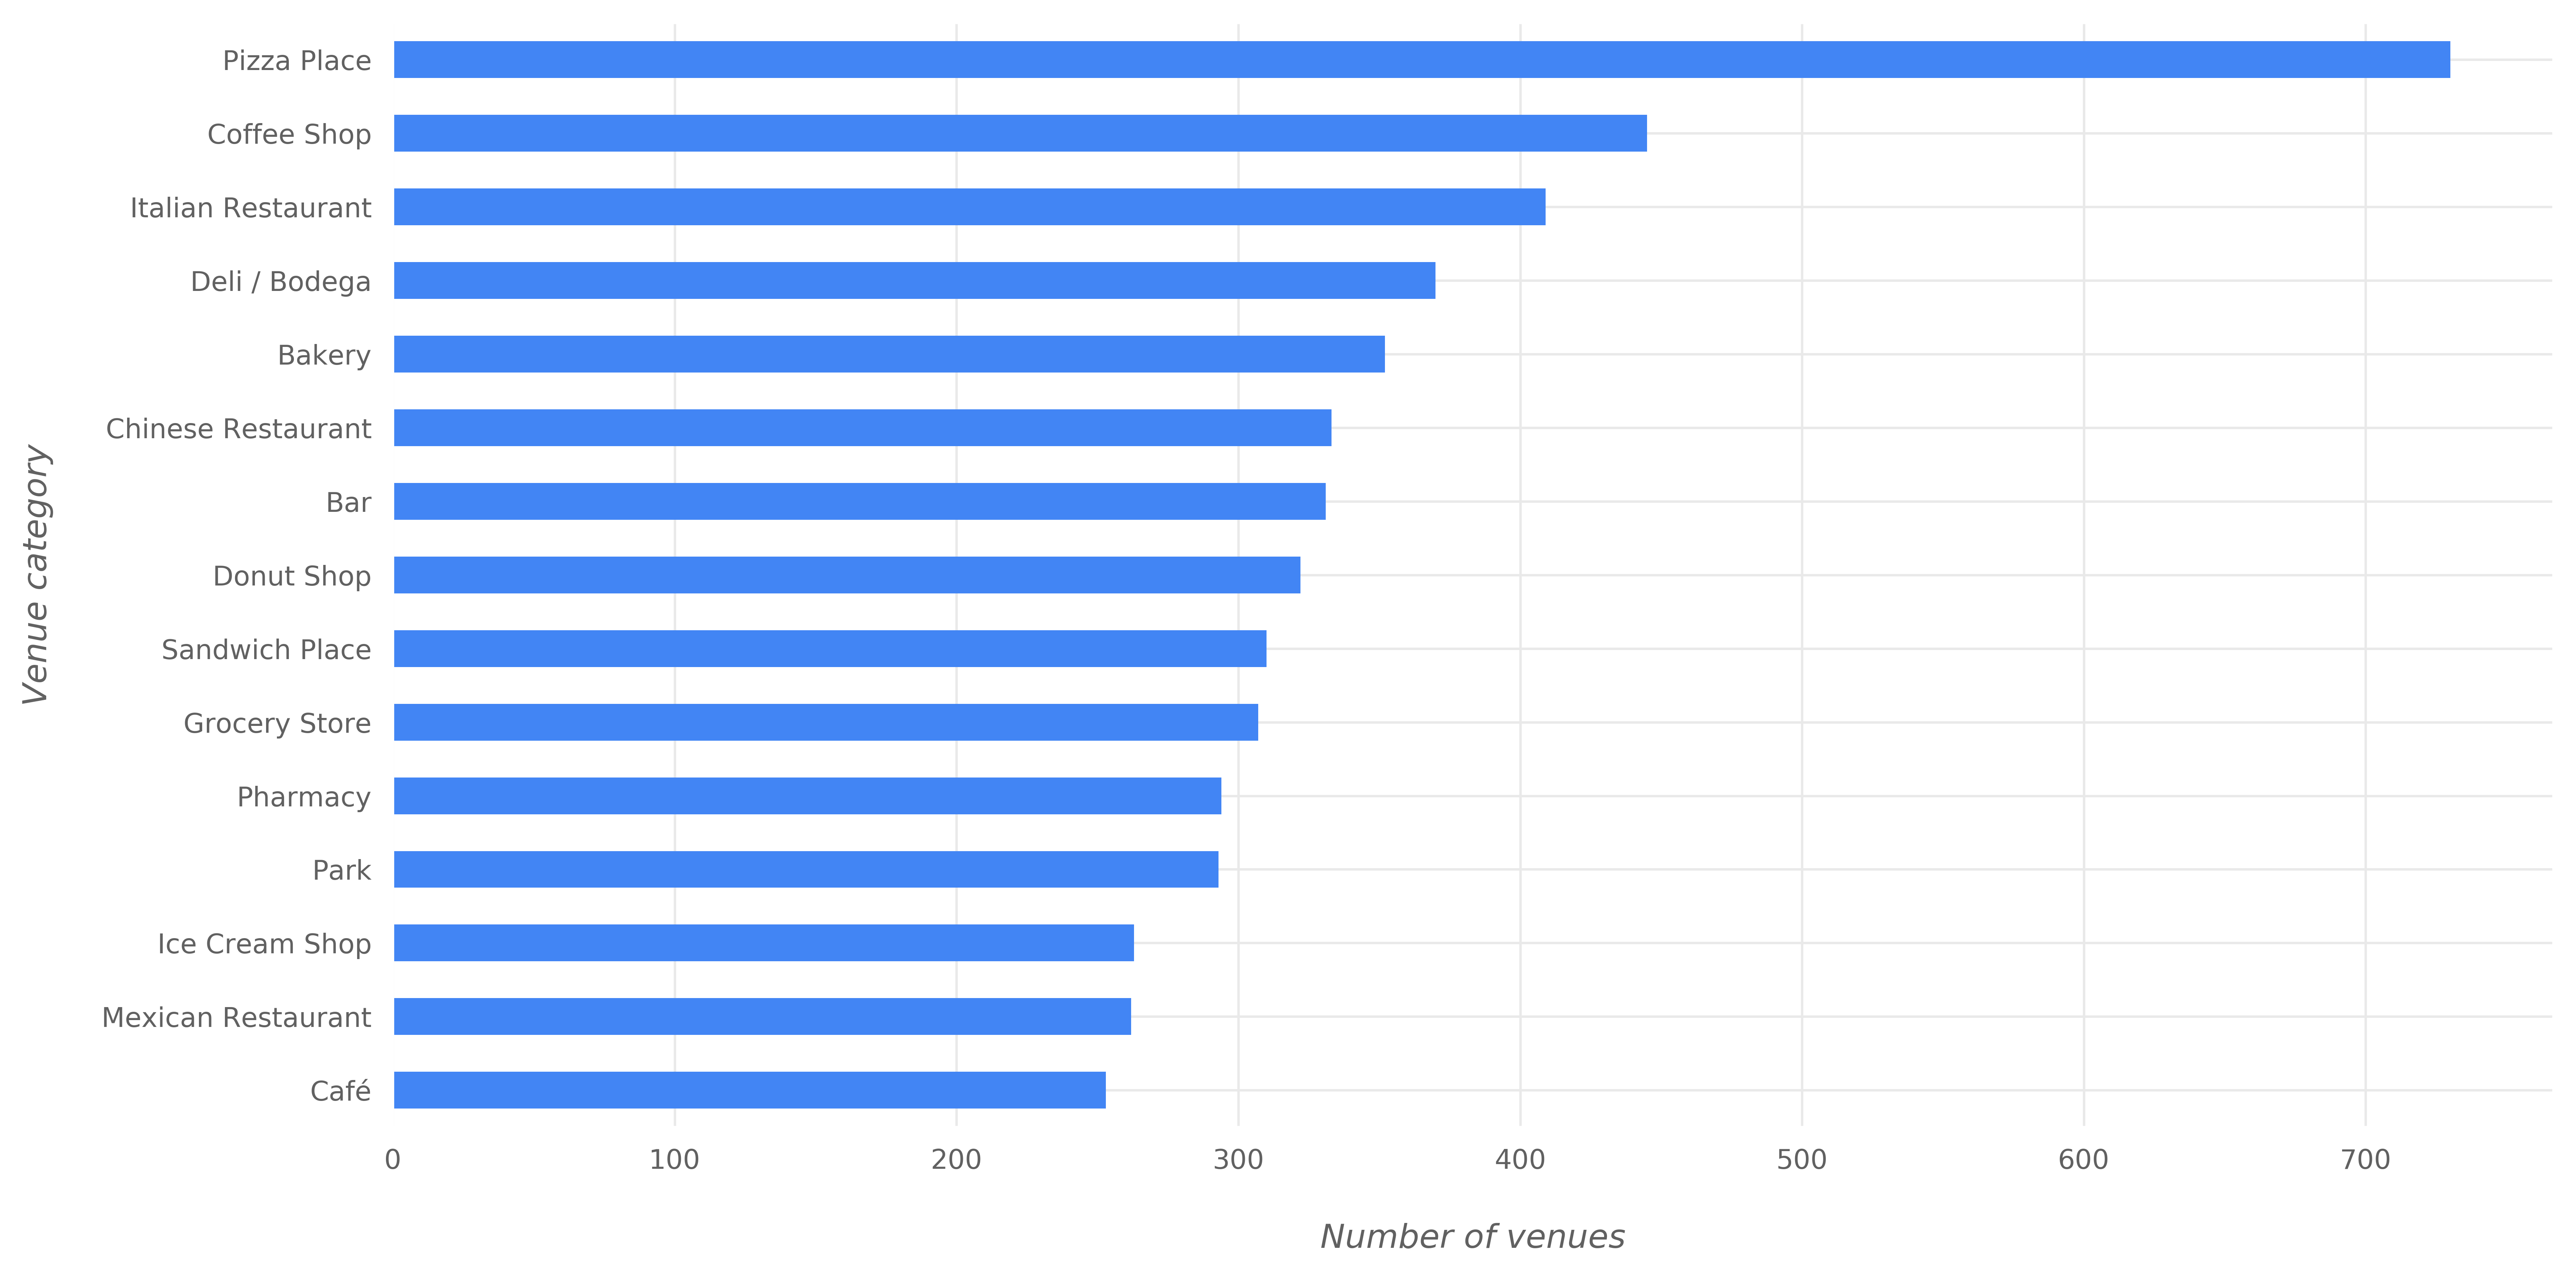

In [131]:

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = NYneighborhoods_venues['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)


<h1>EDA</h1>

<h2>Most Common Venue Categories in NYC</h2>


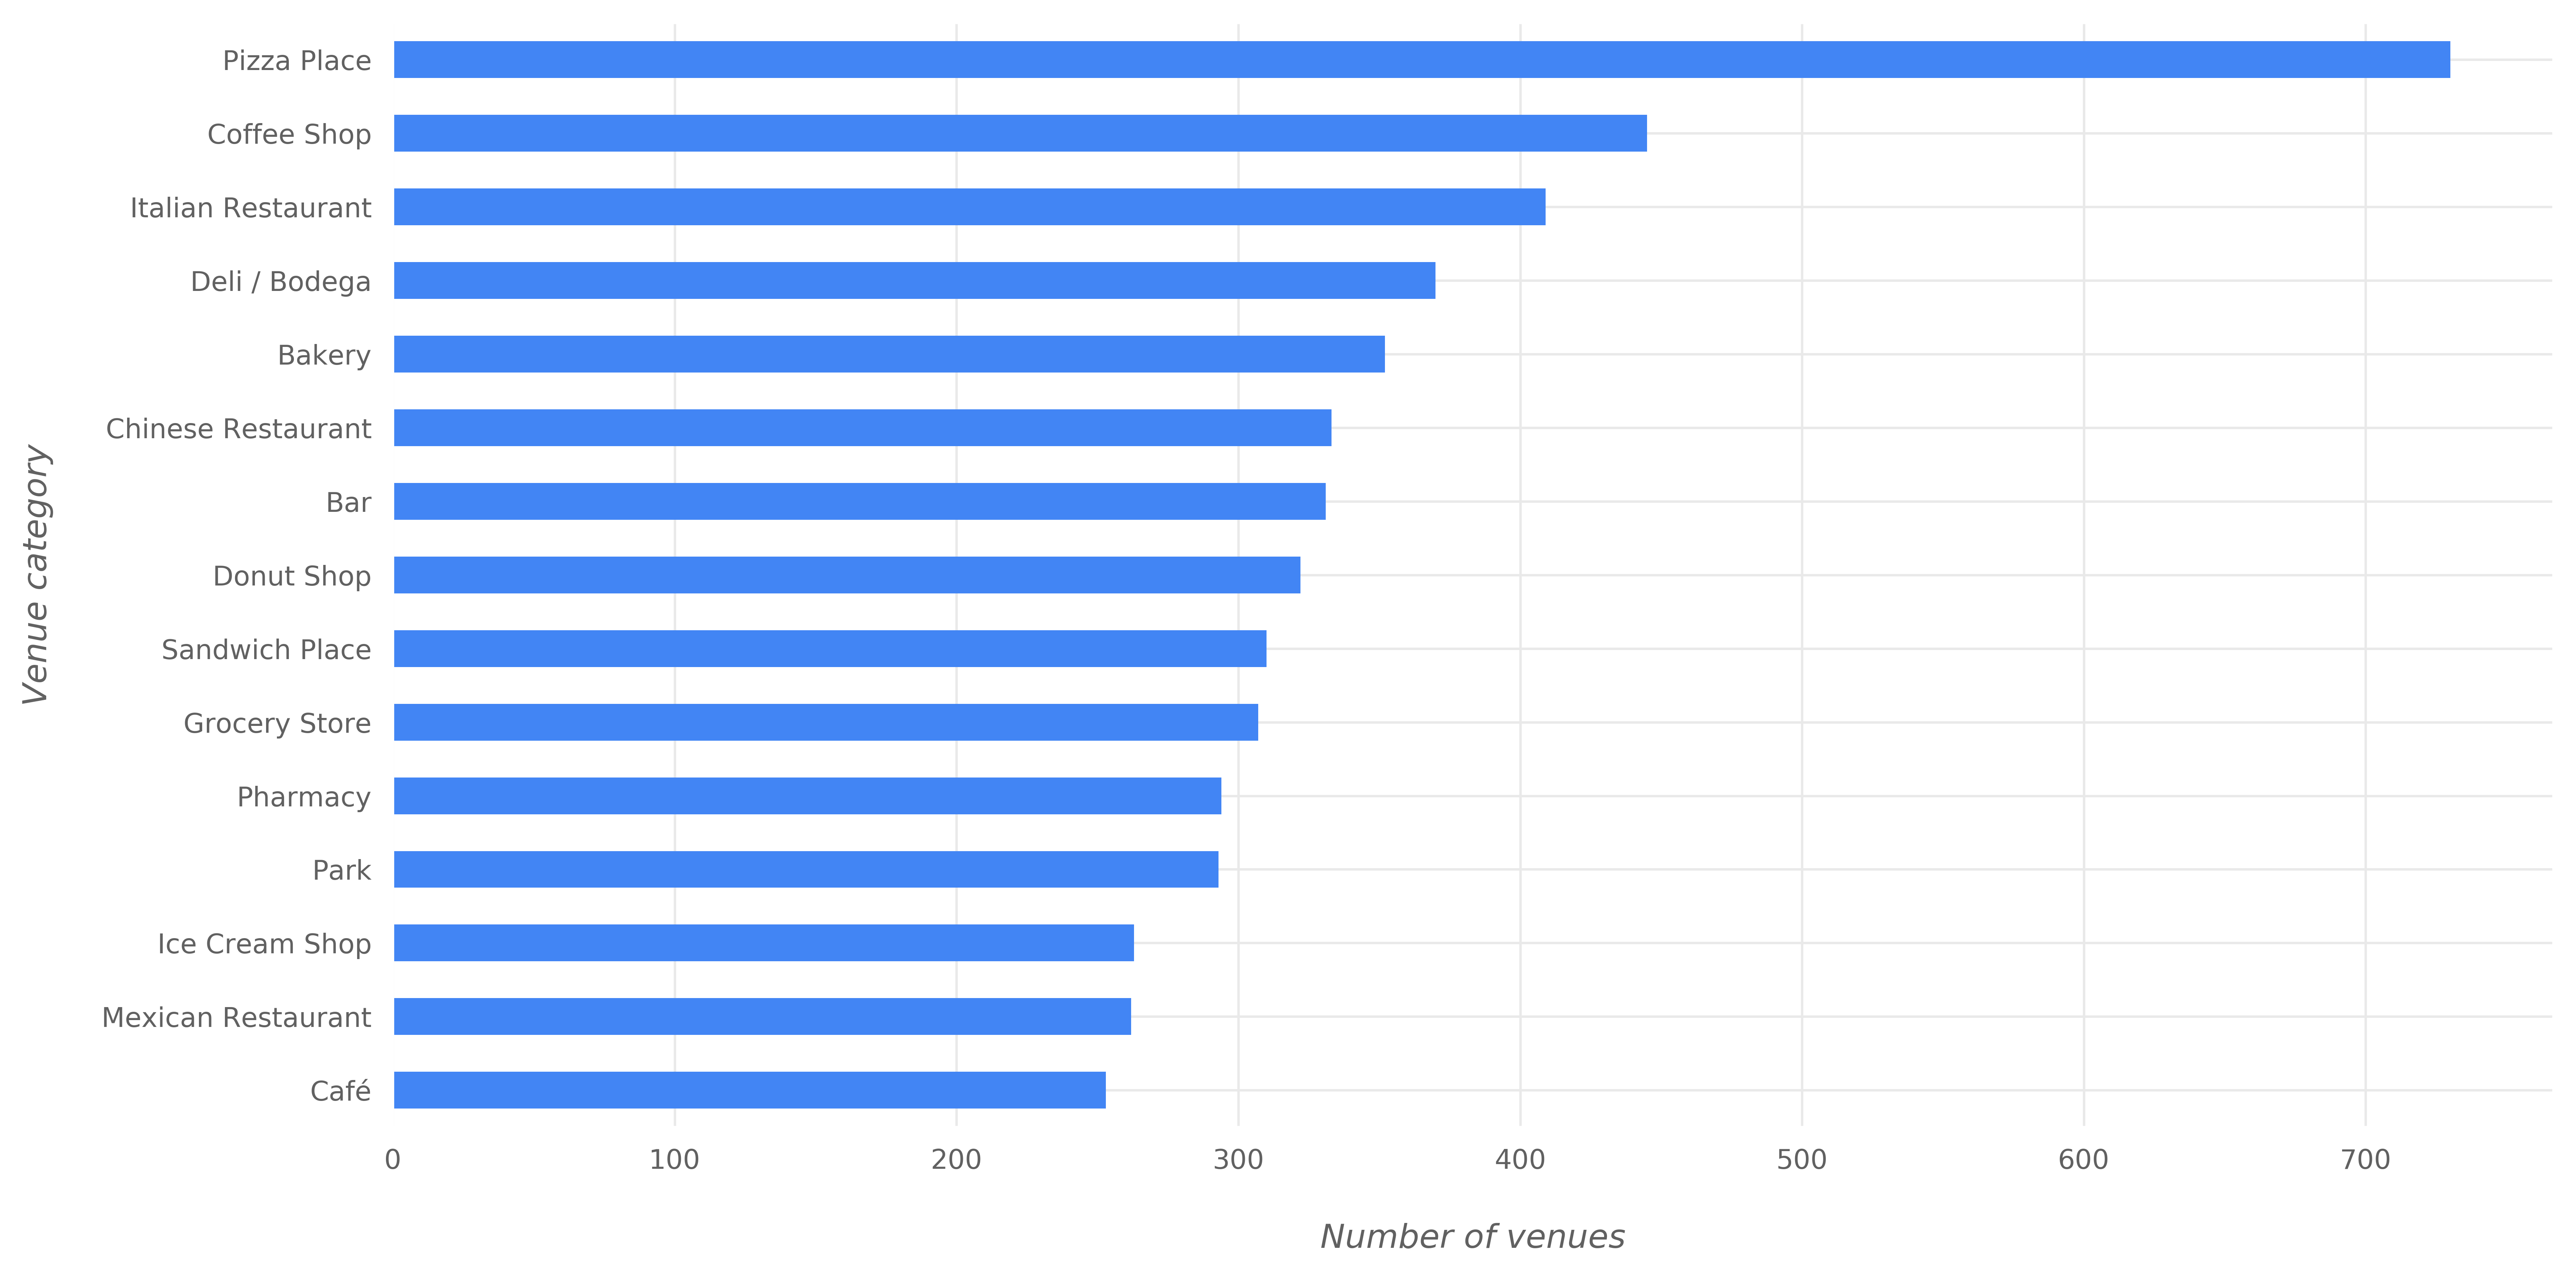

In [132]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = NYneighborhoods_venues['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)

<h2>Most Common Venue Categories in Toronto</h2>


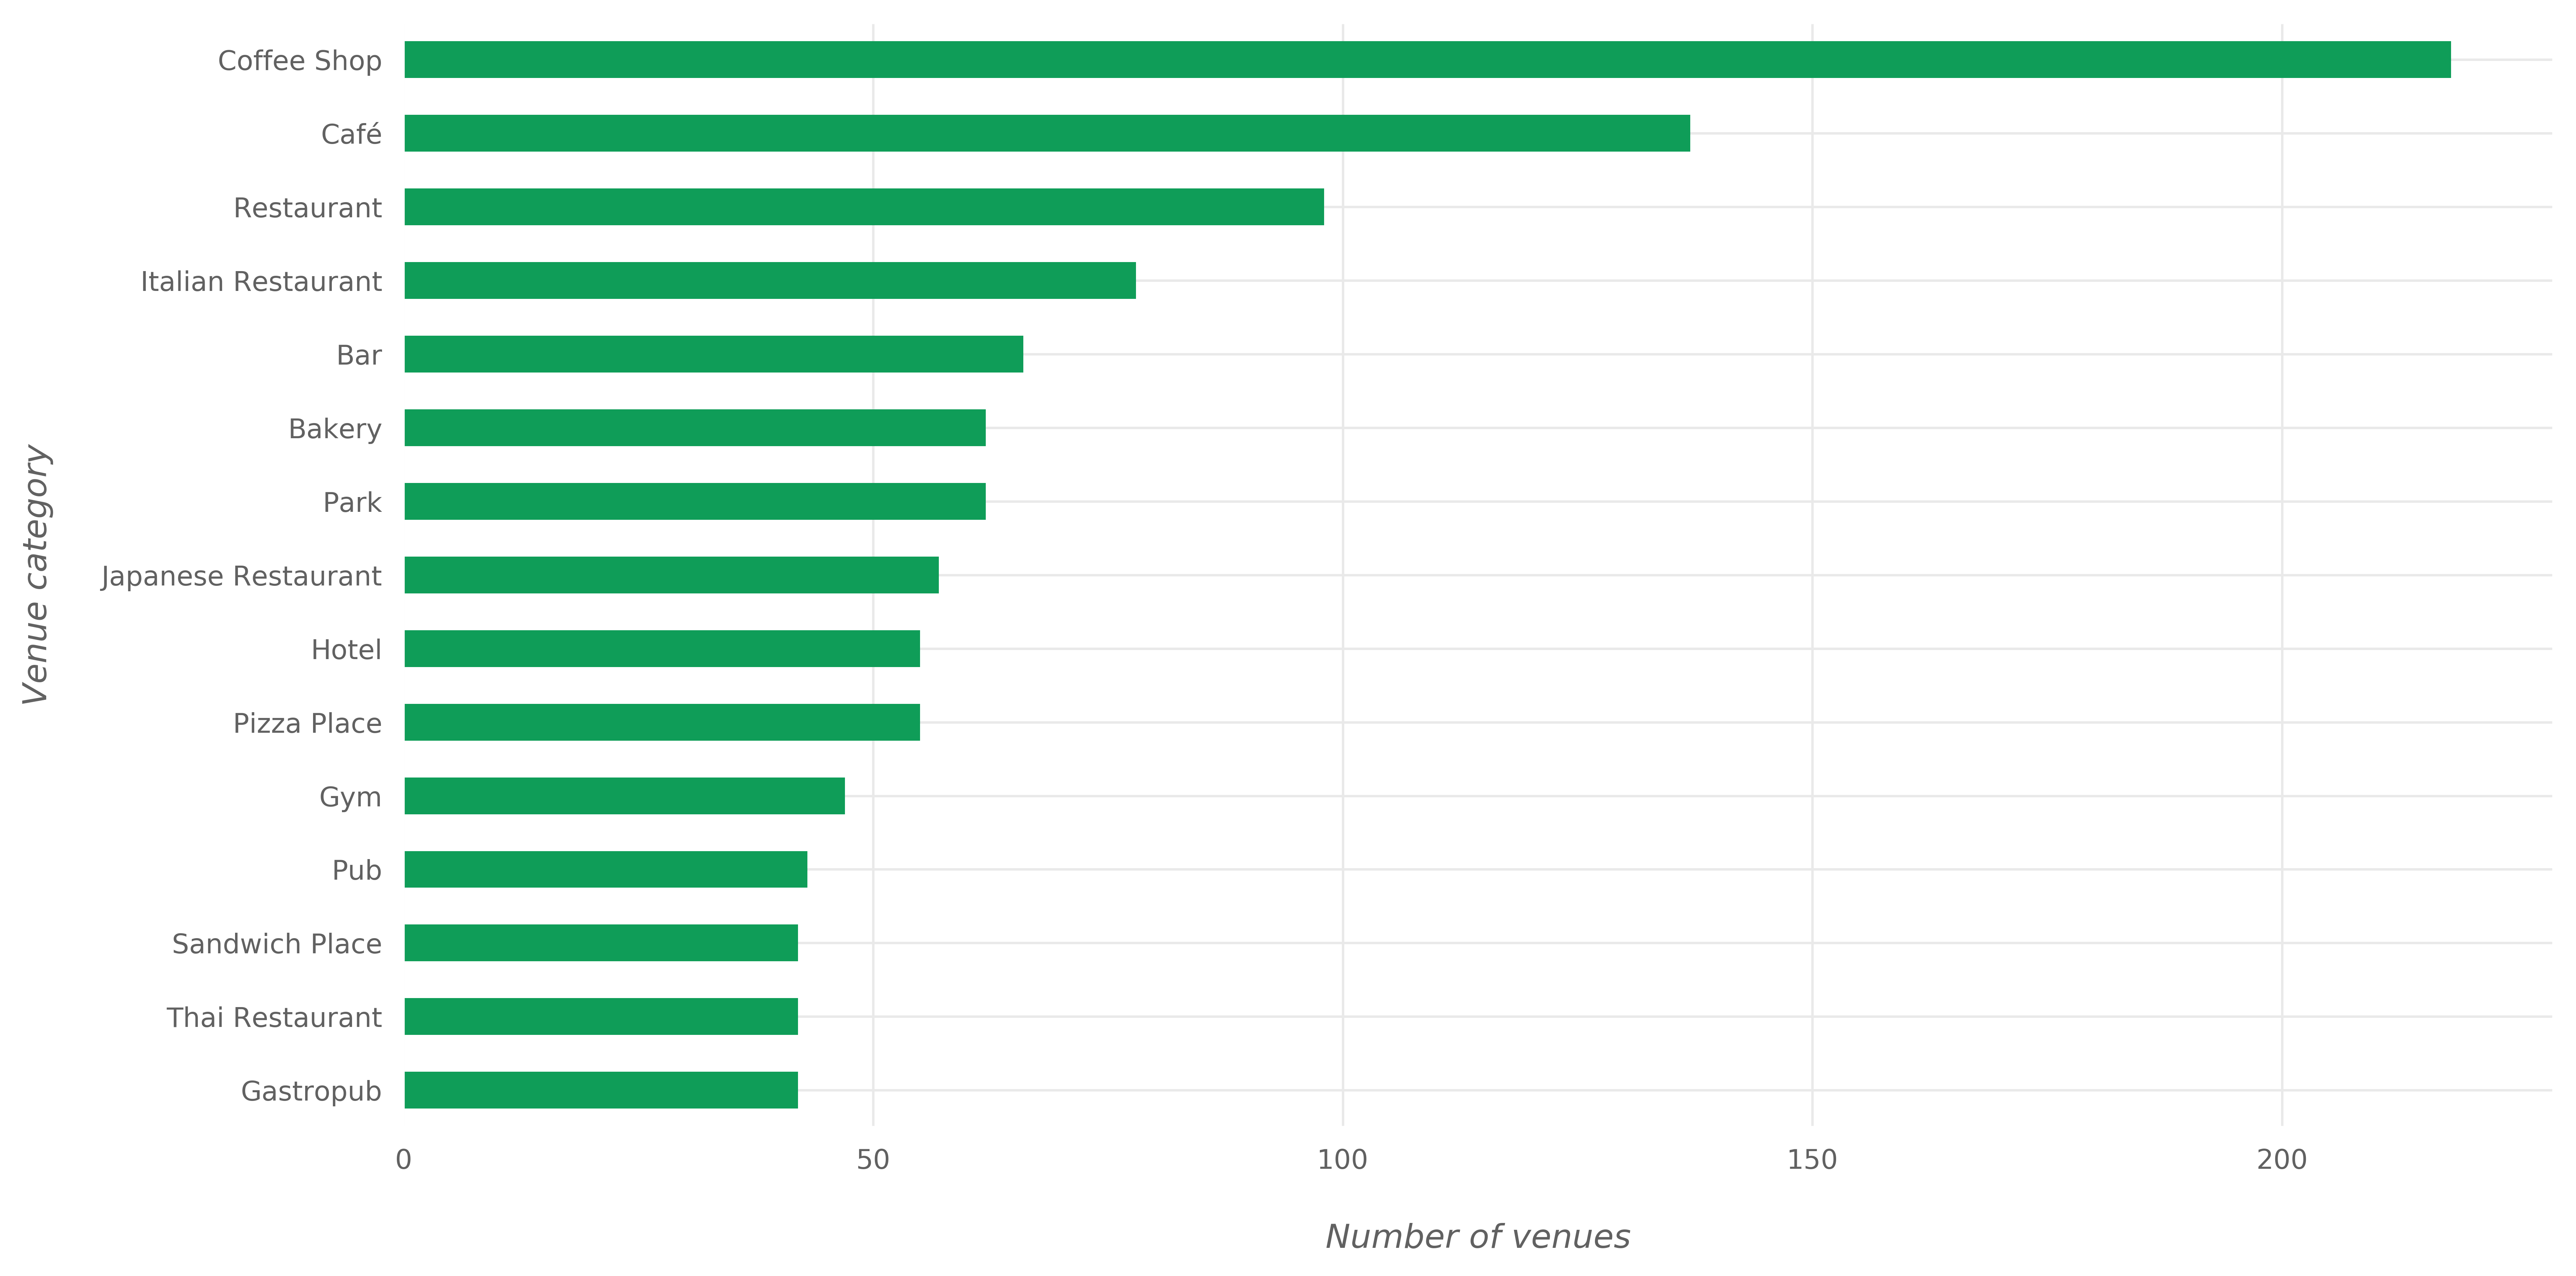

In [134]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_top_vc = tor_venues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color=pc[3]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)

<h2>Which Venue Categories Exist in NYC Neighborhoods?  </h2>


306 neighborhoods in NYC


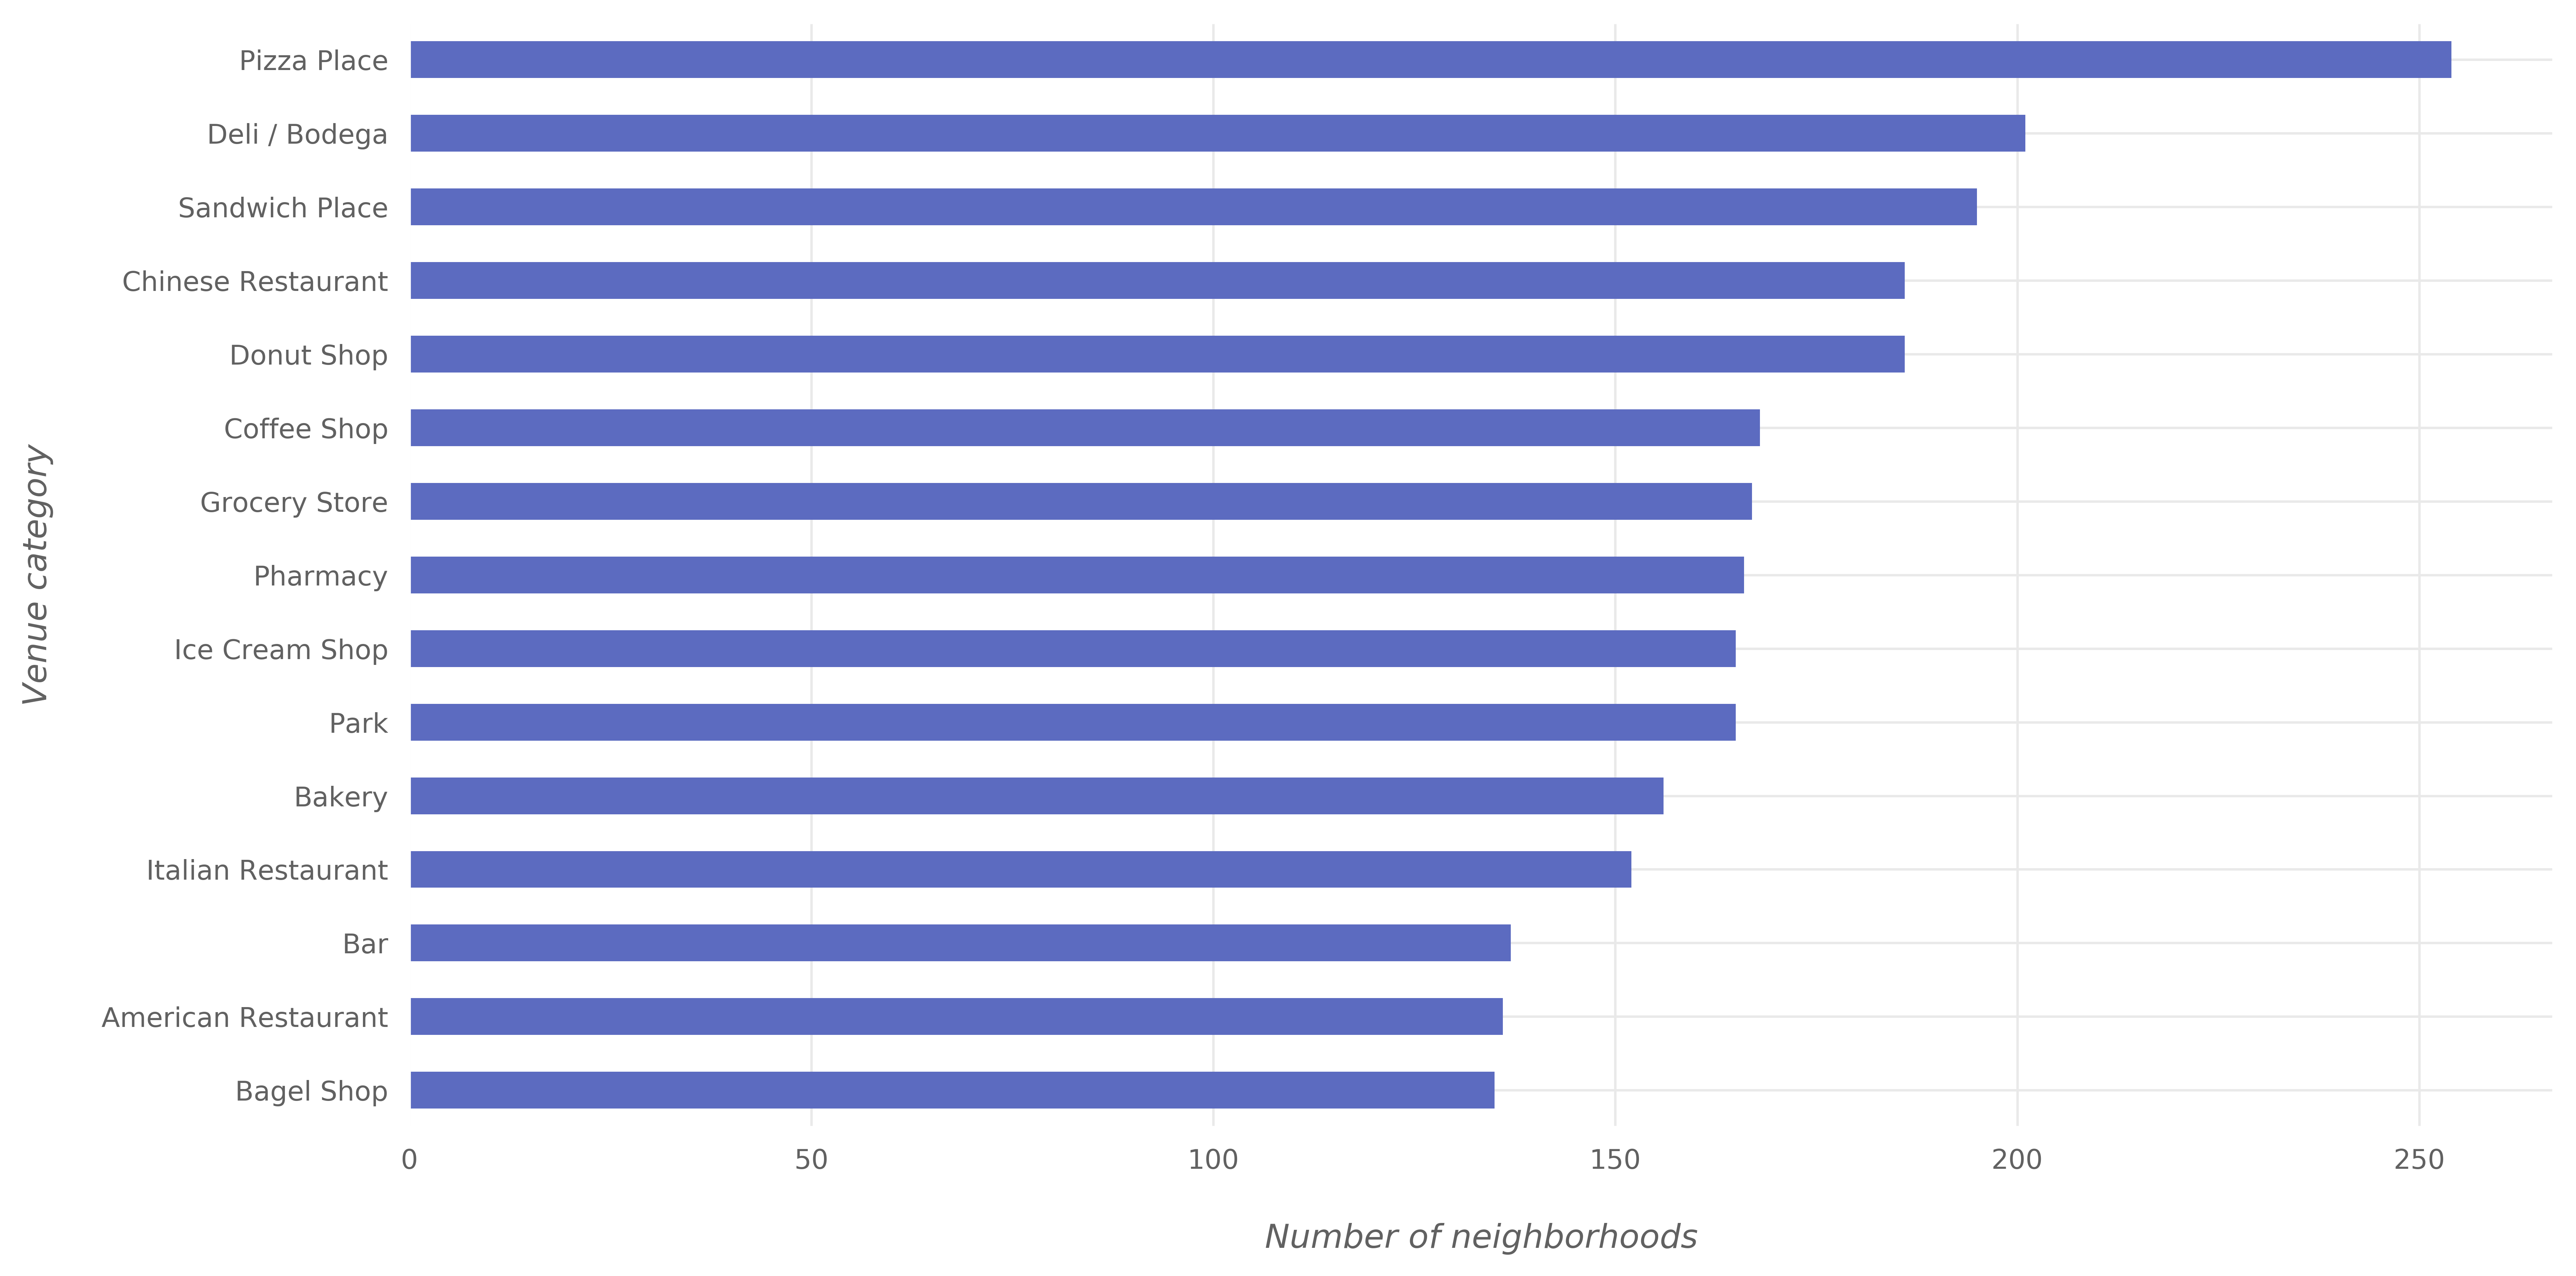

In [138]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_g = NYneighborhoods_onehot.groupby('Neighborhood_').max().reset_index()
nyc_p = nyc_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(nyc_g.shape[0]))
ax = nyc_p.head(15).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-nyc.png', dpi=300)

<h2>Which Venue Categories Exist in Toronto Neighborhoods?</h2>


39 neighborhoods in Toronto


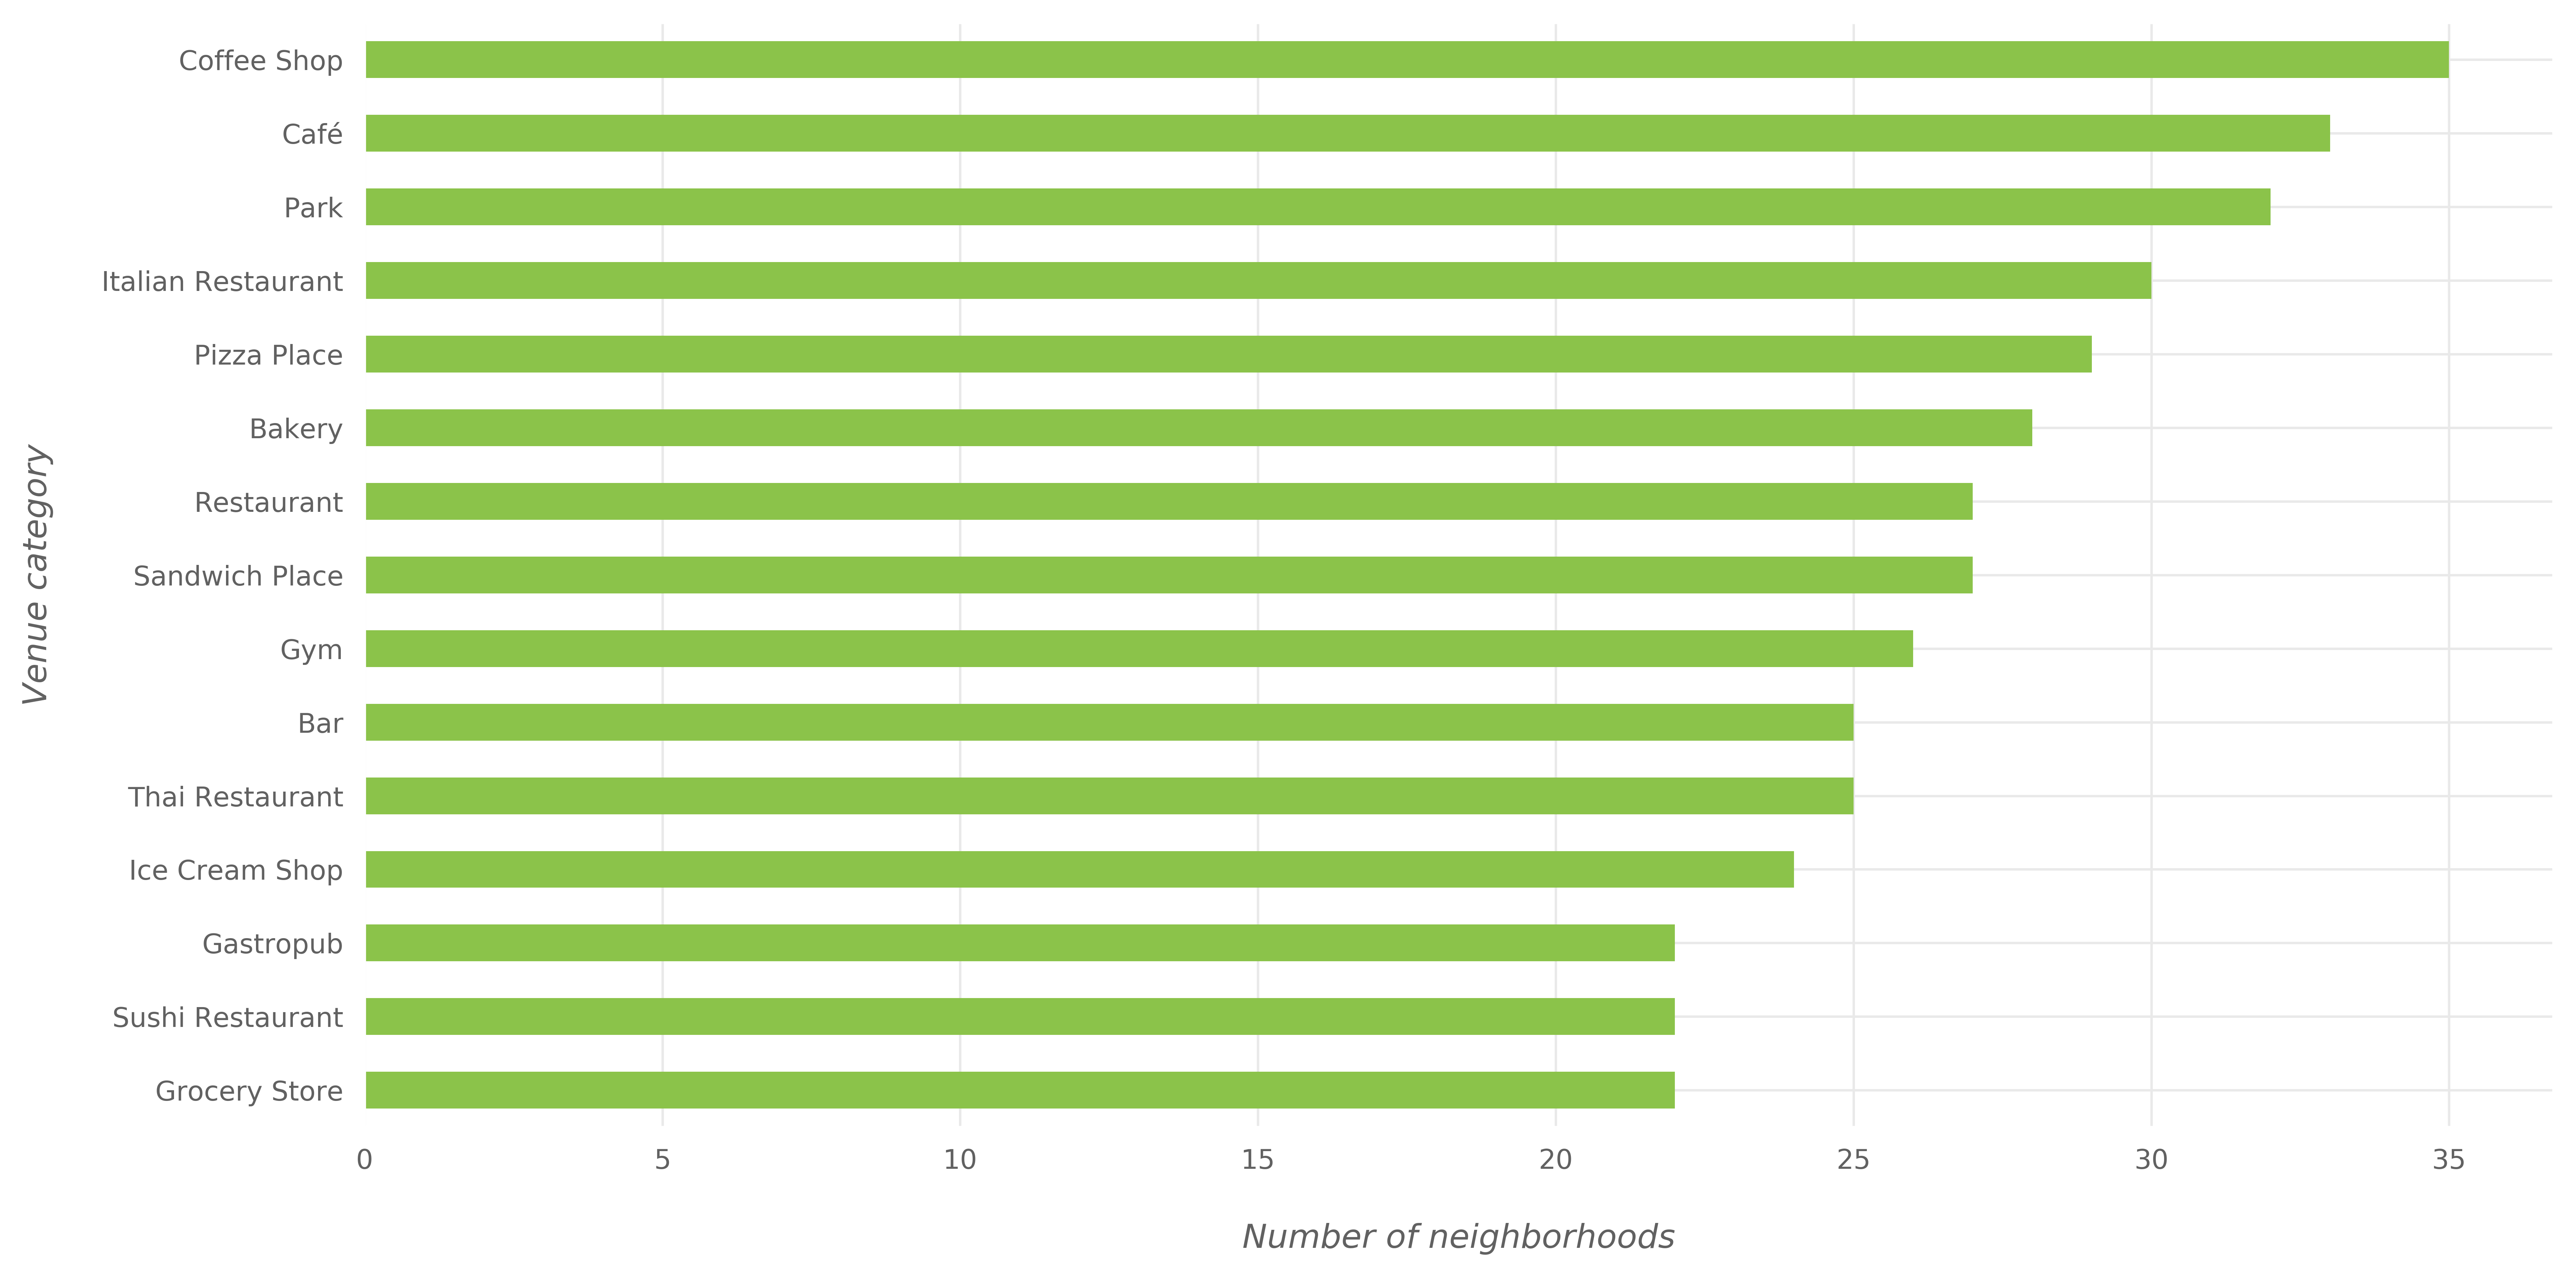

In [139]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_g = tor_onehot.groupby('Neighborhood_').max().reset_index()
tor_p = tor_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in Toronto".format(tor_g.shape[0]))
ax = tor_p.head(15).plot(kind='barh', color=pc[14]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-tor.png', dpi=300)

<h2>Rare Categories in NYC</h2>


In [140]:
nyc_bot_vc = NYneighborhoods_venues['Venue Category'].value_counts(normalize=False)
nyc_bot_vc = nyc_bot_vc.tail(15).to_frame('Count')
nyc_bot_vc.index.names = ['Venue Category']
nyc_bot_vc

Count
Venue Category              
Indonesian Restaurant      1
Stadium                    1
Mountain                   1
Zoo Exhibit                1
Taxi                       1
Airport Lounge             1
Auto Dealership            1
Watch Shop                 1
College Gym                1
Fishing Spot               1
Physical Therapist         1
Platform                   1
Circus                     1
Outdoor Supply Store       1
Campground                 1

<h2>Rare Categories in Toronto</h2>


In [141]:
tor_bot_vc = tor_venues['Venue Category'].value_counts(normalize=False)
tor_bot_vc = tor_bot_vc.tail(15).to_frame('Count')
tor_bot_vc.index.names = ['Venue Category']
tor_bot_vc

Count
Venue Category              
Cupcake Shop               1
Market                     1
Outdoors & Recreation      1
Pastry Shop                1
Soup Place                 1
Airport                    1
River                      1
Storage Facility           1
University                 1
Tech Startup               1
Mac & Cheese Joint         1
Locksmith                  1
Tanning Salon              1
Beach                      1
Farm                       1

In [163]:
tor_grouped

Neighborhood_  Accessories Store  \
0                            Adelaide, King, Richmond           0.000000   
1                                         Berczy Park           0.000000   
2        Brockton, Exhibition Place, Parkdale Village           0.011905   
3   Business Reply Mail Processing Centre 969 Eastern           0.000000   
4   CN Tower, Bathurst Quay, Island airport, Harbo...           0.000000   
5                         Cabbagetown, St. James Town           0.000000   
6                                  Central Bay Street           0.000000   
7           Chinatown, Grange Park, Kensington Market           0.000000   
8                                            Christie           0.000000   
9                                Church and Wellesley           0.000000   
10                     Commerce Court, Victoria Hotel           0.000000   
11                                         Davisville           0.000000   
12                                   Davisville North           0.000000   
13  Deer Park, Forest Hill SE, Rathnelly, South Hi...           0.000000   
14           Design Exchange, Toronto Dominion Centre           0.000000   
15                       Dovercourt Village, Dufferin           0.000000   
16             First Canadian Place, Underground city           0.000000   
17                Forest Hill North, Forest Hill West           0.000000   
18                     Harbord, University of Toronto           0.000000   
19                                       Harbourfront           0.000000   
20  Harbourfront East, Toronto Islands, Union Station           0.000000   
21                      High Park, The Junction South           0.000000   
22                                      Lawrence Park           0.000000   
23                           Little Portugal, Trinity           0.000000   
24                        Moore Park, Summerhill East           0.000000   
25                                 North Toronto West           0.000000   
26                             Parkdale, Roncesvalles           0.000000   
27                                       Queen's Park           0.000000   
28                                           Rosedale           0.000000   
29                                           Roselawn           0.000000   
30                                 Runnymede, Swansea           0.000000   
31                           Ryerson, Garden District           0.000000   
32                                     St. James Town           0.000000   
33                    Stn A PO Boxes 25 The Esplanade           0.000000   
34                                    Studio District           0.000000   
35                The Annex, North Midtown, Yorkville           0.000000   
36                                        The Beaches           0.000000   
37                     The Beaches West, India Bazaar           0.000000   
38                       The Danforth West, Riverdale           0.000000   

    Afghan Restaurant   Airport  Airport Food Court  Airport Gate  \
0                0.00  0.000000            0.000000      0.000000   
1                0.00  0.000000            0.000000      0.000000   
2                0.00  0.000000            0.000000      0.000000   
3                0.00  0.000000            0.000000      0.000000   
4                0.00  0.037037            0.037037      0.037037   
5                0.00  0.000000            0.000000      0.000000   
6                0.00  0.000000            0.000000      0.000000   
7                0.00  0.000000            0.000000      0.000000   
8                0.00  0.000000            0.000000      0.000000   
9                0.01  0.000000            0.000000      0.000000   
10               0.00  0.000000            0.000000      0.000000   
11               0.00  0.000000            0.000000      0.000000   
12               0.00  0.000000            0.000000      0.000000   
13               0.00  0.000000  

In [162]:
clmns_nyc_only = set(NYneighborhoods_grouped.columns).difference(set(tor_grouped.columns))
clmns_tor_only = set(tor_grouped.columns).difference(set(NYneighborhoods_grouped.columns))



Index(['ClusterLabels', 'Postcode', 'Borough', 'Neighborhood_', 'Latitude',
       'Longitude', 'Cluster Labels', '1st Most Common Category',
       '2nd Most Common Category', '3rd Most Common Category',
       '4th Most Common Category', '5th Most Common Category',
       '6th Most Common Category', '7th Most Common Category'],
      dtype='object')

In [223]:
clmns_nyc_only

{'African Restaurant',
 'Arcade',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Austrian Restaurant',
 'Auto Dealership',
 'Auto Garage',
 'Automotive Shop',
 'Basketball Court',
 'Bath House',
 'Beer Garden',
 'Big Box Store',
 'Bike Rental / Bike Share',
 'Bike Trail',
 'Board Shop',
 'Border Crossing',
 'Botanical Garden',
 'Bowling Alley',
 'Boxing Gym',
 'Bridal Shop',
 'Bridge',
 'Buffet',
 'Caucasian Restaurant',
 'Check Cashing Service',
 'College Academic Building',
 'College Bookstore',
 'Community Center',
 'Construction & Landscaping',
 'Convention Center',
 'Cruise',
 'Cycle Studio',
 'Distillery',
 'Dry Cleaner',
 'Empanada Restaurant',
 'Entertainment Service',
 'Event Service',
 'Exhibit',
 'Factory',
 'Field',
 'Film Studio',
 'Financial or Legal Service',
 'Fishing Spot',
 'Fishing Store',
 'Go Kart Track',
 'Golf Course',
 'Gymnastics Gym',
 'Halal Restaurant',
 'Herbs & Spices Store',
 'High School',
 'Hobby Shop',
 'Home Service',
 'Hookah Bar',
 'Indie Theater

In [224]:
clmns_tor_only

{'Afghan Restaurant',
 'Airport',
 'Airport Food Court',
 'Airport Gate',
 'Airport Lounge',
 'Airport Service',
 'Airport Terminal',
 'Amphitheater',
 'Aquarium',
 'Baby Store',
 'Beach Bar',
 'Bed & Breakfast',
 'Belgian Restaurant',
 'Castle',
 'Chiropractor',
 'Churrascaria',
 'College Arts Building',
 'College Gym',
 'College Rec Center',
 'College Theater',
 'Costume Shop',
 'Curling Ice',
 'Design Studio',
 'Distribution Center',
 'Doner Restaurant',
 'Festival',
 'Fountain',
 'General Travel',
 'Gluten-free Restaurant',
 'Hawaiian Restaurant',
 'Hotel Bar',
 'IT Services',
 'Indian Chinese Restaurant',
 'Indonesian Restaurant',
 'Jewish Restaurant',
 'Light Rail Station',
 'Modern European Restaurant',
 'Molecular Gastronomy Restaurant',
 'Music School',
 'Neighborhood_',
 'Pastry Shop',
 'Portuguese Restaurant',
 'Poutine Place',
 'Swim School',
 'Syrian Restaurant',
 'Tanning Salon',
 'Tech Startup',
 'Theme Restaurant',
 'Tram Station',
 'Tunnel',
 'Udon Restaurant',
 'Unive

In [143]:
nyc_grouped_ = NYneighborhoods_grouped.copy()

nyc_grouped_['Neighborhood_'] = nyc_grouped_['Neighborhood_'].apply(lambda x: x + '_NY')

#nyc_grouped_

tor_grouped_ = tor_grouped.copy()
tor_grouped_['Neighborhood_'] = tor_grouped_['Neighborhood_'].apply(lambda x: x + '_TOR')
#tor_grouped_

for c in clmns_tor_only:
    nyc_grouped_[c] = 0
for c in clmns_nyc_only:
    tor_grouped_[c] = 0


all_clmns_sorted = ['Neighborhood_'] + sorted(list(nyc_grouped_.drop('Neighborhood_', axis=1).columns), key=str.lower)
all_clmns_sorted
nyc_grouped_ = nyc_grouped_[all_clmns_sorted]
tor_grouped_ = tor_grouped_[all_clmns_sorted]
    
nyc_tor_grouped = pd.concat([nyc_grouped_, tor_grouped_]).reset_index(drop=True)


In [144]:
nyc_tor_grouped.loc[300:310,]

Neighborhood_  Accessories Store  \
300                                         Wingate_NY           0.000000   
301                                       Woodhaven_NY           0.000000   
302                                        Woodlawn_NY           0.000000   
303                                         Woodrow_NY           0.000000   
304                                        Woodside_NY           0.000000   
305                                       Yorkville_NY           0.000000   
306                       Adelaide, King, Richmond_TOR           0.000000   
307                                    Berczy Park_TOR           0.000000   
308   Brockton, Exhibition Place, Parkdale Village_TOR           0.011905   
309  Business Reply Mail Processing Centre 969 East...           0.000000   
310  CN Tower, Bathurst Quay, Island airport, Harbo...           0.000000   

     Adult Boutique  Afghan Restaurant  African Restaurant   Airport  \
300             0.0                0.0                 0.0  0.000000   
301             0.0                0.0                 0.0  0.000000   
302             0.0                0.0                 0.0  0.000000   
303             0.0                0.0                 0.0  0.000000   
304             0.0                0.0                 0.0  0.000000   
305             0.0                0.0                 0.0  0.000000   
306             0.0                0.0                 0.0  0.000000   
307             0.0                0.0                 0.0  0.000000   
308             0.0                0.0                 0.0  0.000000   
309             0.0                0.0                 0.0  0.000000   
310             0.0                0.0                 0.0  0.037037   

     Airport Food Court  Airport Gate  Airport Lounge  Airport Service  ...  \
300            0.000000      0.000000        0.000000         0.000000  ...   
301            0.000000      0.000000        0.000000         0.000000  ...   
302            0.000000      0.000000        0.000000         0.000000  ...   
303            0.000000      0.000000        0.000000         0.000000  ...   
304            0.000000      0.000000        0.000000         0.000000  ...   
305            0.000000      0.000000        0.000000         0.000000  ...   
306            0.000000      0.000000        0.000000         0.000000  ...   
307            0.000000      0.000000        0.000000         0.000000  ...   
308            0.000000      0.000000        0.000000         0.000000  ...   
309            0.000000      0.000000        0.000000         0.000000  ...   
310            0.037037      0.037037        0.074074         0.111111  ...   

     Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  \
300                 0.0         0.0  0.000000   0.000000     0.0     0.020408   
301                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
302                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
303                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
304                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
305                 0.0         0.0  0.010000   0.020000     0.0     0.000000   
306                 0.0         0.0  0.010101   0.000000     0.0     0.000000   
307                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
308                 0.0         0.0  0.000000   0.000000     0.0     0.000000   
309                 0.0         0.0  0.000000   0.018519     0.0     0.000000   
310                 0.0         0.0  0.000000   0.000000     0.0     0.000000   

     Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
300            0.0     0.000000  0.0          0.0  
301            0.0     0.000000  0.0          0.0  
302            0.0     0.000000  0.0          0.0  
303            0.0     0.000000  0.0          0.0  
304            0.0     0.000000  0.0          0.0  
305            0.

In [112]:
nyc_tor_grouped.shape

(345, 485)

In [145]:
# obtaining the most popular categories for each neighborhood

nyc_tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_tor_neighborhoods_categories_sorted['Neighborhood_'] = nyc_tor_grouped['Neighborhood_']

for ind in np.arange(nyc_tor_grouped.shape[0]):
    nyc_tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_tor_grouped.iloc[ind, :], num_top_cat)

nyc_tor_neighborhoods_categories_sorted.head()

Neighborhood_ 1st Most Common Category 2nd Most Common Category  \
0       Allerton_NY              Pizza Place               Donut Shop   
1       Annadale_NY              Pizza Place               Restaurant   
2  Arden Heights_NY       Mexican Restaurant                 Pharmacy   
3      Arlington_NY            Deli / Bodega              Snack Place   
4       Arrochar_NY                    Beach       Italian Restaurant   

  3rd Most Common Category 4th Most Common Category 5th Most Common Category  \
0           Sandwich Place     Fast Food Restaurant                 Pharmacy   
1         Sushi Restaurant                    Diner               Sports Bar   
2                      Spa       Chinese Restaurant           Sandwich Place   
3                Juice Bar              Coffee Shop             Home Service   
4            Deli / Bodega              Pizza Place           Baseball Field   

  6th Most Common Category 7th Most Common Category  
0                     Food           Discount Store  
1      American Restaurant                     Park  
2              Coffee Shop             Liquor Store  
3            Boat or Ferry             Intersection  
4         Sculpture Garden    Outdoors & Recreation

In [ ]:
NYneighborhoods_grouped=NYneighborhoods_grouped

In [146]:
nyc_tor_bot_vc = pd.concat([NYneighborhoods_venues, tor_venues])['Venue Category'].value_counts(normalize=False)
nyc_tor_bot_vc = nyc_tor_bot_vc.tail(15).to_frame('Count')
nyc_tor_bot_vc.index.names = ['Venue Category']
nyc_tor_bot_vc

Count
Venue Category             
Souvenir Shop             1
Syrian Restaurant         1
Volleyball Court          1
Plane                     1
Auditorium                1
Mountain                  1
Vape Store                1
Cooking School            1
Gun Range                 1
Baby Store                1
Theme Restaurant          1
Medical Supply Store      1
Leather Goods Store       1
Taxi                      1
College Cafeteria         1

In [148]:
# the number of clusters
kclusters = 5

nyc_tor_grouped_clustering = nyc_tor_grouped.drop('Neighborhood_', 1)
nyc_tor_grouped_clustering
# run k-means clustering

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([0, 0, 0, 0, 0, 0, 4, 4, 0, 0], dtype=int32)

In [149]:
# add clustering labels
nyc_tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_tor_merged = nyc_tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_tor_merged = nyc_tor_neighborhoods_categories_sorted.set_index('Neighborhood_')

nyc_tor_merged.iloc[300:310] # check the last columns!

Cluster Labels  \
Neighborhood_                                                        
Wingate_NY                                                       0   
Woodhaven_NY                                                     0   
Woodlawn_NY                                                      0   
Woodrow_NY                                                       0   
Woodside_NY                                                      4   
Yorkville_NY                                                     4   
Adelaide, King, Richmond_TOR                                     4   
Berczy Park_TOR                                                  4   
Brockton, Exhibition Place, Parkdale Village_TOR                 4   
Business Reply Mail Processing Centre 969 Easte...               4   

                                                     1st Most Common Category  \
Neighborhood_                                                                   
Wingate_NY                                                        Pizza Place   
Woodhaven_NY                                        Latin American Restaurant   
Woodlawn_NY                                                               Bar   
Woodrow_NY                                                      Grocery Store   
Woodside_NY                                                   Thai Restaurant   
Yorkville_NY                                                              Gym   
Adelaide, King, Richmond_TOR                                      Coffee Shop   
Berczy Park_TOR                                                   Coffee Shop   
Brockton, Exhibition Place, Parkdale Village_TOR                  Coffee Shop   
Business Reply Mail Processing Centre 969 Easte...       Fast Food Restaurant   

                                                   2nd Most Common Category  \
Neighborhood_                                                                 
Wingate_NY                                                    Grocery Store   
Woodhaven_NY                                                    Pizza Place   
Woodlawn_NY                                                   Deli / Bodega   
Woodrow_NY                                                         Pharmacy   
Woodside_NY                                                          Bakery   
Yorkville_NY                                             Italian Restaurant   
Adelaide, King, Richmond_TOR                                           Café   
Berczy Park_TOR                                                  Restaurant   
Brockton, Exhibition Place, Parkdale Village_TOR                       Café   
Business Reply Mail Processing Centre 969 Easte...                      Bar   

                                                   3rd Most Common Category  \
Neighborhood_                                                                 
Wingate_NY                                              Fried Chicken Joint   
Woodhaven_NY                                                  Deli / Bodega   
Woodlawn_NY                                                             Pub   
Woodrow_NY                                                       Donut Shop   
Woodside_NY                                                             Bar   
Yorkville_NY                                                    Coffee Shop   
Adelaide, King, Richmond_TOR                                     Restaurant   
Berczy Park_TOR                                                       Hotel   
Brockton, Exhibition Place, Parkdale Village_TOR                  Gift Shop   
Business Reply Mail Processing Centre 969 Easte...              Coffee Shop   

                                                   4th Most Common Category  \
Neighborhood_                                                                 
Wingate_NY                                                         Pharmacy   
Woodhaven_NY                                                    Supermarket   
Woodlawn_NY             

In [ ]:
Cluster 1

In [147]:
c1 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 0, :]
print(c1.shape)
c1.iloc[60:70]

(162, 8)


Cluster Labels 1st Most Common Category  \
Neighborhood_                                                  
Lighthouse Hill_NY                0                    Trail   
Lincoln Square_NY                 0                    Plaza   
Little Italy_NY                   0       Italian Restaurant   
Little Neck_NY                    0       Italian Restaurant   
Long Island City_NY               0                    Hotel   
Lower East Side_NY                0              Art Gallery   
Manhattan Beach_NY                0          Harbor / Marina   
Manhattan Valley_NY               0                     Park   
Manhattanville_NY                 0       Chinese Restaurant   
Midtown_NY                        0              Coffee Shop   

                    2nd Most Common Category 3rd Most Common Category  \
Neighborhood_                                                           
Lighthouse Hill_NY            Clothing Store               Bagel Shop   
Lincoln Square_NY         Italian Restaurant                  Theater   
Little Italy_NY               Cosmetics Shop                     Café   
Little Neck_NY            Chinese Restaurant                     Bank   
Long Island City_NY              Coffee Shop              Pizza Place   
Lower East Side_NY            Ice Cream Shop       Mexican Restaurant   
Manhattan Beach_NY              Dessert Shop       Turkish Restaurant   
Manhattan Valley_NY        Indian Restaurant              Coffee Shop   
Manhattanville_NY                       Park       Mexican Restaurant   
Midtown_NY                             Hotel                    Plaza   

                    4th Most Common Category 5th Most Common Category  \
Neighborhood_                                                           
Lighthouse Hill_NY                       Spa                     Café   
Lincoln Square_NY          French Restaurant             Concert Hall   
Little Italy_NY               Ice Cream Shop             Cocktail Bar   
Little Neck_NY                   Coffee Shop                   Bakery   
Long Island City_NY       Mexican Restaurant     Gym / Fitness Center   
Lower East Side_NY               Coffee Shop      Japanese Restaurant   
Manhattan Beach_NY                Restaurant       Seafood Restaurant   
Manhattan Valley_NY              Pizza Place       Chinese Restaurant   
Manhattanville_NY         Italian Restaurant              Coffee Shop   
Midtown_NY                       Pizza Place      Japanese Restaurant   

                      6th Most Common Category 7th Most Common Category  
Neighborhood_                                                            
Lighthouse Hill_NY              History Museum               Art Museum  
Lincoln Square_NY         Gym / Fitness Center                     Park  
Little Italy_NY                 Sandwich Place                    Hotel  
Little Neck_NY       Middle Eastern Restaurant        Mobile Phone Shop  
Long Island City_NY            Bubble Tea Shop        Indian Restaurant  
Lower East Side_NY            Asian Restaurant              Pizza Place  
Manhattan Beach_NY                        Lake           Sandwich Place  
Manhattan Valley_NY                        Bar                Wine Shop  
Manhattanville_NY                  Pizza Place                     Café  
Midtown_NY                      Sandwich Place                   Bakery

In [ ]:
Cluster 2

In [148]:
c2 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 1, :]
print(c2.shape)
c2

(1, 8)


Cluster Labels 1st Most Common Category  \
Neighborhood_                                            
Todt Hill_NY                1                 Mountain   

              2nd Most Common Category 3rd Most Common Category  \
Neighborhood_                                                     
Todt Hill_NY               Zoo Exhibit                 Festival   

              4th Most Common Category 5th Most Common Category  \
Neighborhood_                                                     
Todt Hill_NY        English Restaurant    Entertainment Service   

              6th Most Common Category 7th Most Common Category  
Neighborhood_                                                    
Todt Hill_NY      Ethiopian Restaurant            Event Service

In [ ]:
Cluster 3

In [149]:
c3 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 2, :]
print(c3.shape)
c3.tail()

(170, 8)


Cluster Labels 1st Most Common Category  \
Neighborhood_                                             
Willowbrook_NY               2               Bagel Shop   
Wingate_NY                   2              Pizza Place   
Woodhaven_NY                 2            Deli / Bodega   
Woodlawn_NY                  2                      Pub   
Woodrow_NY                   2            Grocery Store   

                 2nd Most Common Category 3rd Most Common Category  \
Neighborhood_                                                        
Willowbrook_NY         Chinese Restaurant              Pizza Place   
Wingate_NY                     Donut Shop            Deli / Bodega   
Woodhaven_NY    Latin American Restaurant              Pizza Place   
Woodlawn_NY                           Bar            Deli / Bodega   
Woodrow_NY                     Donut Shop                    Diner   

               4th Most Common Category 5th Most Common Category  \
Neighborhood_                                                      
Willowbrook_NY              Zoo Exhibit           Farmers Market   
Wingate_NY                Grocery Store      Fried Chicken Joint   
Woodhaven_NY                   Pharmacy              Supermarket   
Woodlawn_NY                 Pizza Place       Italian Restaurant   
Woodrow_NY                         Bank                   Bakery   

               6th Most Common Category 7th Most Common Category  
Neighborhood_                                                     
Willowbrook_NY       English Restaurant    Entertainment Service  
Wingate_NY                     Pharmacy           Sandwich Place  
Woodhaven_NY        Fried Chicken Joint           Sandwich Place  
Woodlawn_NY              Discount Store            Grocery Store  
Woodrow_NY                         Park             Liquor Store

In [ ]:
Cluster 4

In [121]:
c4 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 3, :]
print(c4.shape)
c4

(6, 8)


Cluster Labels 1st Most Common Category  \
Neighborhood_                                               
Belle Harbor_NY                3                    Beach   
Butler Manor_NY                3           Baseball Field   
Midland Beach_NY               3                    Beach   
Neponsit_NY                    3                    Beach   
Sea Gate_NY                    3                    Beach   
South Beach_NY                 3                    Beach   

                 2nd Most Common Category    3rd Most Common Category  \
Neighborhood_                                                           
Belle Harbor_NY                       Spa                         Pub   
Butler Manor_NY         Convenience Store                        Pool   
Midland Beach_NY           Baseball Field                  Restaurant   
Neponsit_NY                          Park                 Pizza Place   
Sea Gate_NY                   Supermarket  Construction & Landscaping   
South Beach_NY                       Pier                Soccer Field   

                 4th Most Common Category 5th Most Common Category  \
Neighborhood_                                                        
Belle Harbor_NY             Deli / Bodega               Donut Shop   
Butler Manor_NY               Zoo Exhibit     Fast Food Restaurant   
Midland Beach_NY     Other Great Outdoors                Pet Store   
Neponsit_NY                   Zoo Exhibit           Farmers Market   
Sea Gate_NY           American Restaurant              Pizza Place   
South Beach_NY         Athletics & Sports      American Restaurant   

                 6th Most Common Category 7th Most Common Category  
Neighborhood_                                                       
Belle Harbor_NY                    Bakery               Bagel Shop  
Butler Manor_NY        English Restaurant    Entertainment Service  
Midland Beach_NY             Liquor Store                Bookstore  
Neponsit_NY            English Restaurant    Entertainment Service  
Sea Gate_NY                           Spa                     Park  
South Beach_NY              Deli / Bodega               Skate Park

In [ ]:
Cluster 5

In [120]:
c5 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 4, :]
print(c5.shape)
c5

(6, 8)


Cluster Labels  \
Neighborhood_                                             
Bayswater_NY                                          4   
Clason Point_NY                                       4   
Howland Hook_NY                                       4   
Malba_NY                                              4   
Forest Hill North, Forest Hill West_TOR               4   
Rosedale_TOR                                          4   

                                        1st Most Common Category  \
Neighborhood_                                                      
Bayswater_NY                                          Playground   
Clason Point_NY                                             Park   
Howland Hook_NY                                  Harbor / Marina   
Malba_NY                                                    Park   
Forest Hill North, Forest Hill West_TOR                     Park   
Rosedale_TOR                                                Park   

                                           2nd Most Common Category  \
Neighborhood_                                                         
Bayswater_NY                             Construction & Landscaping   
Clason Point_NY                                       Boat or Ferry   
Howland Hook_NY                                              Resort   
Malba_NY                                                 Playground   
Forest Hill North, Forest Hill West_TOR            Sushi Restaurant   
Rosedale_TOR                                                  Trail   

                                        3rd Most Common Category  \
Neighborhood_                                                      
Bayswater_NY                                                Park   
Clason Point_NY                                    Moving Target   
Howland Hook_NY                                             Park   
Malba_NY                                          Cosmetics Shop   
Forest Hill North, Forest Hill West_TOR            Jewelry Store   
Rosedale_TOR                                         Candy Store   

                                        4th Most Common Category  \
Neighborhood_                                                      
Bayswater_NY                                  Athletics & Sports   
Clason Point_NY                                      Zoo Exhibit   
Howland Hook_NY                                      Zoo Exhibit   
Malba_NY                                               Rest Area   
Forest Hill North, Forest Hill West_TOR     Gym / Fitness Center   
Rosedale_TOR                                          Playground   

                                        5th Most Common Category  \
Neighborhood_                                                      
Bayswater_NY                                Fast Food Restaurant   
Clason Point_NY                                         Festival   
Howland Hook_NY                                   Farmers Market   
Malba_NY                                              Food Truck   
Forest Hill North, Forest Hill West_TOR              Dry Cleaner   
Rosedale_TOR                                         Flea Market   

                                        6th Most Common Category  \
Neighborhood_                                                      
Bayswater_NY                                  English Restaurant   
Clason Point_NY                            Entertainment Service   
Howland Hook_NY                              Empanada Restaurant   
Malba_NY                                         Harbor / Marina   
Forest Hill North, Forest Hill West_TOR                    Trail   
Rosedale_TOR                                  Falafel Restaurant   

                                        7th Most Common Category  
Neighborhood_                                                     
Bayswater_NY                               Entertainment Service  
Clason Point_NY                             Ethiopian Restaurant  
Howlan

In [185]:
clust_cats = []
clusters = [c1, c2, c3, c4, c5]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('NY'):
            nn = n[:-3]
            clust_cats[i].extend(list(NYneighborhoods_venues[NYneighborhoods_venues['Neighborhood'] == nn]['Venue Category'].values))

        else:
            nn = n[:-4]
            clust_cats[i].extend(list(tor_venues[tor_venues['Neighborhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100


In [176]:
clust_cats[1]

Series([], dtype: float64)

In [154]:
tbl_bck = "#363636"
tbl_hdr_bck = "#363636"
tbl_txt = "#BBBBBB"

styles = [
    dict(selector="td", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector="th", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector=".col0", props=[("border-left", "1px solid #bbbbbb")]), 
    
    dict(selector="th.blank:nth-child(2)", props=[("border-left", "1px solid #bbbbbb")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("padding-top", "0"), ("padding-bottom", "8px")]),
    
    dict(selector="th.col_heading", props=[("background", tbl_hdr_bck), 
                                           ("color", "#FFCA91")]),
    
    dict(selector="th.index_name", props=[("background", tbl_hdr_bck), 
                                          ("color", "#8DCDFF")]),
    
    dict(selector="th.blank", props=[("background", tbl_hdr_bck), ("padding", "0")]),
    
    dict(selector="tr:nth-child(2n)", props=[("background", "white")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "1px solid {}".format(tbl_txt))]),
    
    dict(selector="thead tr:nth-child(1) th", props=[("padding-top", "14px !important")]),
    
    dict(selector="tbody tr:last-child td", props=[("padding-bottom", "20px")]),
    
    dict(selector="tbody tr:last-child th", props=[("padding-bottom", "20px")]),
    
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "#8DCDFF")]),
]

In [186]:
for i in range(kclusters):
    c__ = clust_cats[i].to_frame("% of venues")
    c__.index.names = ['Category']
    html = (c__.head(7).style.set_table_styles(styles)
            .set_table_attributes('style="border-collapse: collapse; border: 2px solid #BBBBBB"'))
    display(HTML(disp_fmt.format("Cluster {}".format(i+1))))
    display(html)
    


In [189]:
n_counts = []
for c in clusters:
    nyc_c = 0
    tor_c = 0
    for n in c.index.values:
        if n.endswith('NY'):
            nyc_c += 1
        else:
            tor_c += 1
    n_counts.append((nyc_c, tor_c))

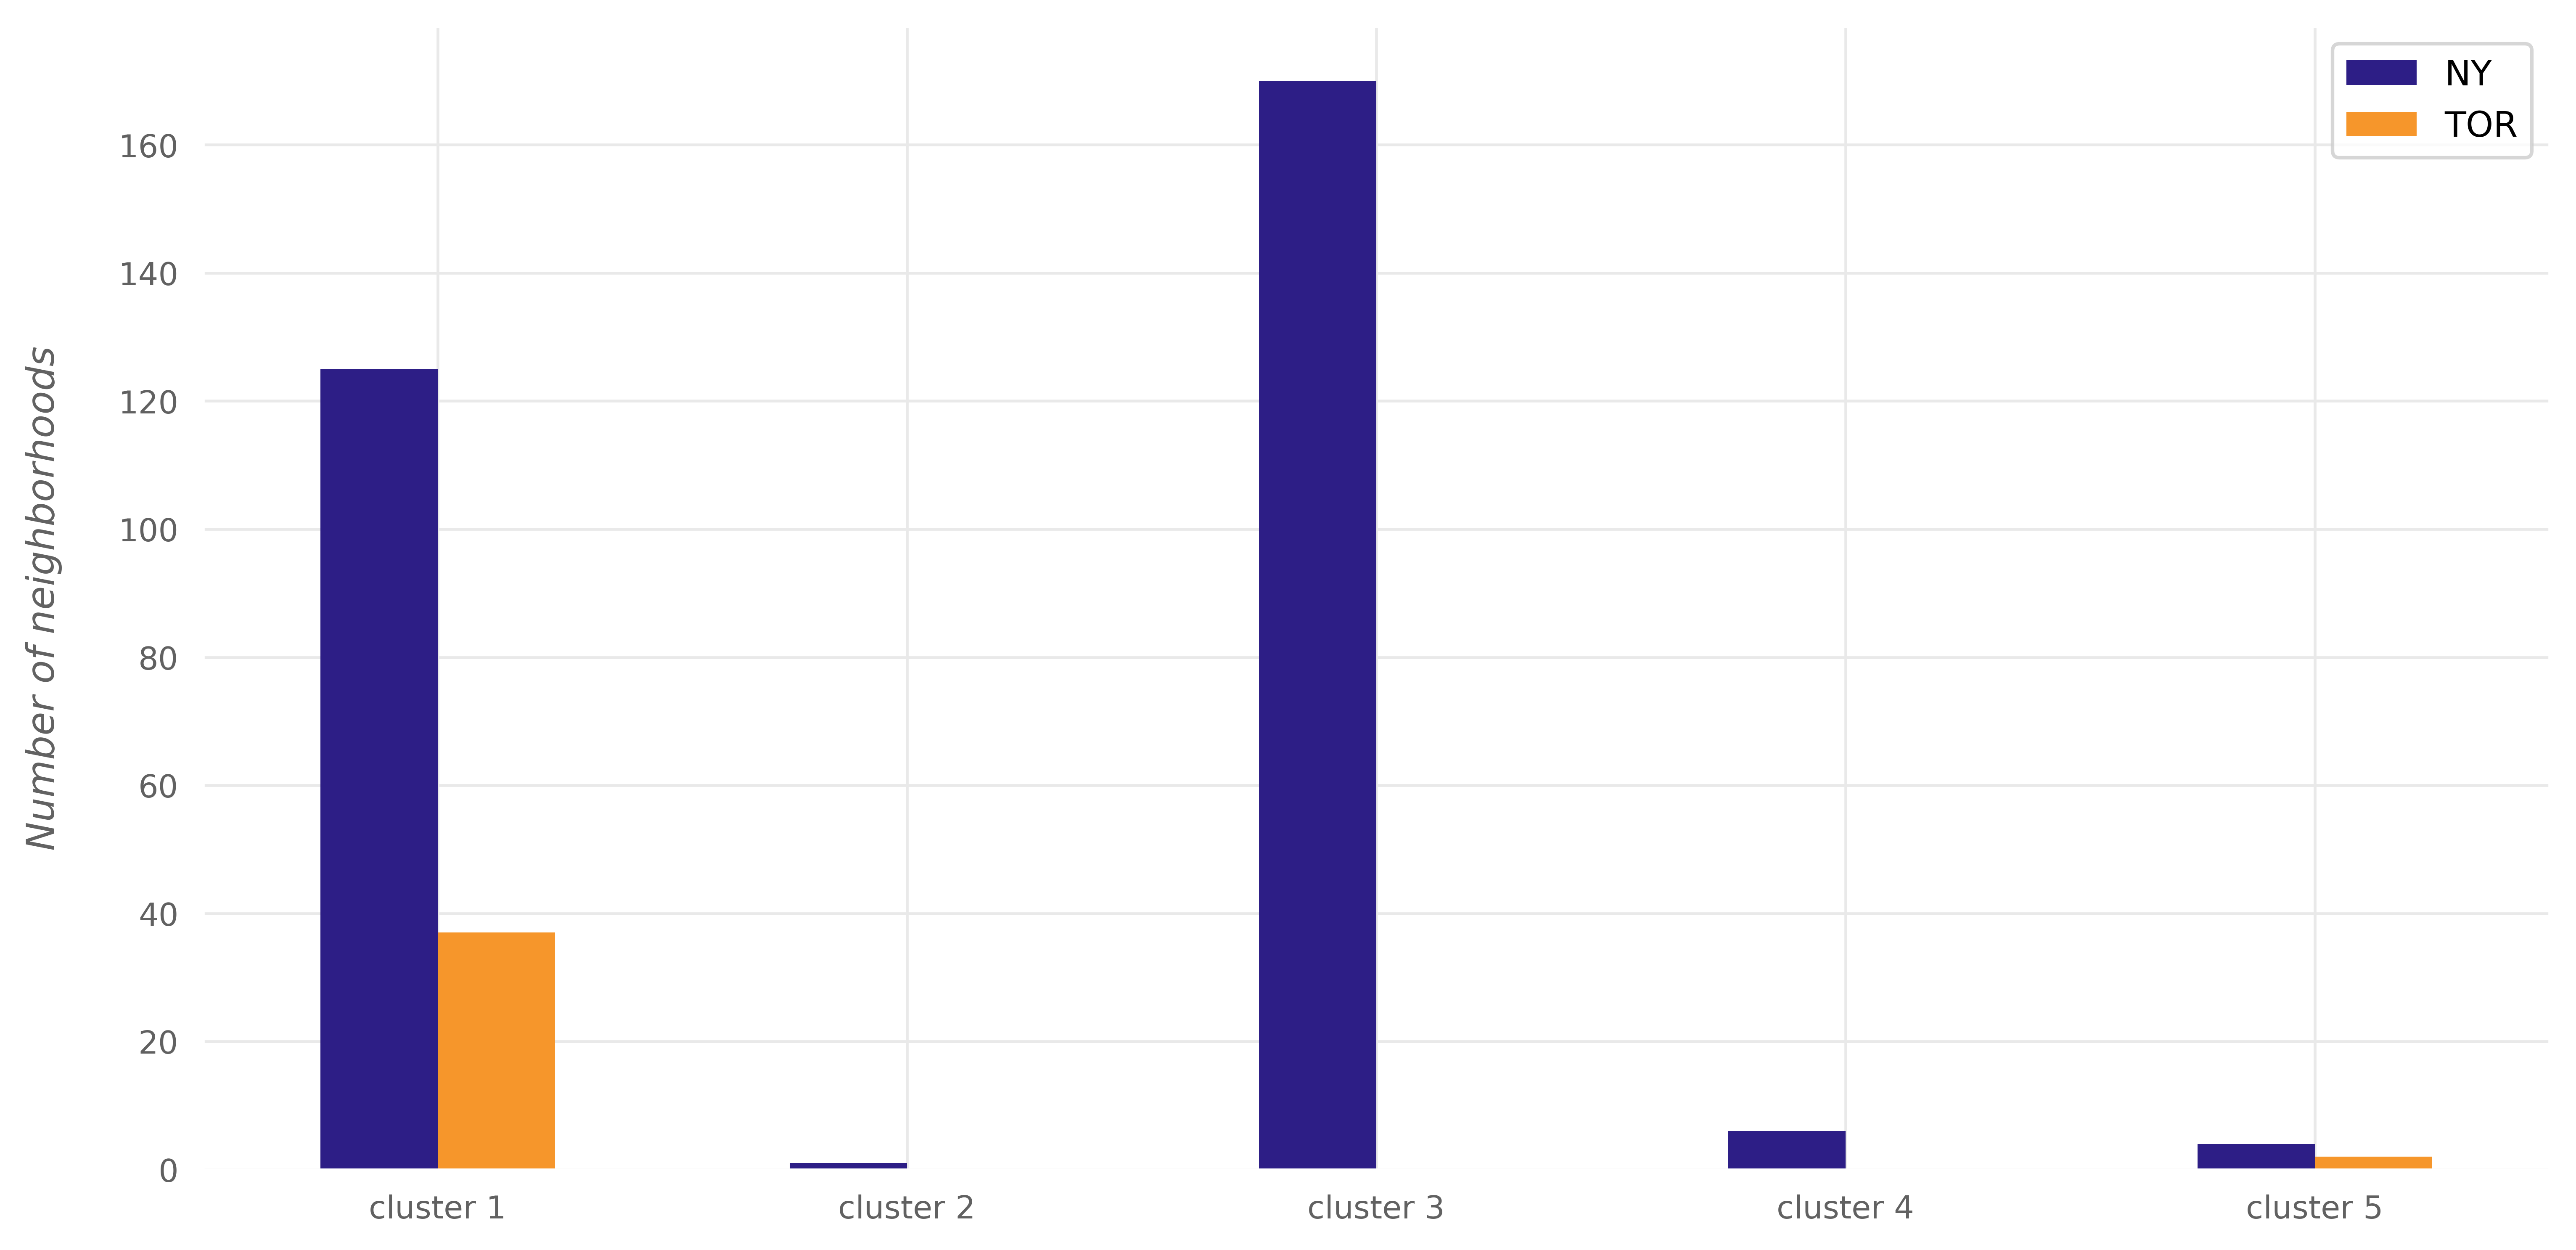

In [190]:
ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'NY': [x[0] for x in n_counts],
    'TOR': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
city_c_df.plot(kind='bar', color=['#2d1e86', '#f6962b'], rot=0, ax=ax)
plot_conf(ax, xlbl='', ylbl='Number of neighborhoods', t='')
fig.savefig('city-count.png', dpi=300)